In [1]:
#Boiler plate imports
import uproot 
import pandas as pd
import sys
import matplotlib.pyplot as plt
import numpy as np
from time import time
from scipy.interpolate import interp1d

import xml.etree.ElementTree as ET

#SBND imports
sys.path.append('/sbnd/app/users/brindenc/mysbnana_v09_75_03/srcs/sbnana/sbnana/SBNAna/pyana')
from sbnd.general import utils,plotters
from sbnd.plotlibrary import makeplot
from sbnd import stats as sbndstats
from sbnd import prism
from sbnd.constants import *
from sbnd.cafclasses import object_calc

%load_ext autoreload
%autoreload 2

In [2]:
#Variables
save_plots = True #save plots
close_plots = False #close plots after saving
save_df = True #save postprocessed dataframes
#variables for setting and checking data
check_flux = False #check flux histograms
load_dfs = True #load postprocessed dataframes
make_dfs = False #make from genie trees

#Normalization constants
flux_pot_norm = 1e6 #Flux normalized to 1e6 pot
m2_per_cm2 = 1e-4 #m^2 per cm^2
n_events = 1e6 #events in each sample
ratio_mcp_to_g18 = [18610/0.2117749 #0th prism bin
  ,55342/0.6452452 #1st prism bin
  ,88414/1.0591616 #2nd prism bin
  ,102354/1.3367942 #3rd prism bin
  ,101847/1.4145875 #4th prism bin
  ,71133/1.1684591 #5th prism bin
  ]
#ratio of mcp to g18 events, measured by ratio in MCP plot and G18 with weighting
ratio_mcp_to_g18_mean = np.mean(ratio_mcp_to_g18)
ratio_mcp_to_g18_unc = np.std(ratio_mcp_to_g18)/ratio_mcp_to_g18_mean

#Constants
PLOTS_DIR = f'Plots/gevgencc_prism_{plotters.day}'
DATA_DIR = '/sbnd/data/users/brindenc/genie/crpa/gevgens/numu/prism_processed/100k'

CRPA_LABEL = 'HF-CRPA (G21_11a)'
G21_LABEL = 'SuSAv2 (G21_11a)'
G18_LABEL = 'NAV (G18_10a_02_11a)'
HYBRID_LABEL = 'HF-CRPA SuSAv2 (G21_11a)'
MODEL_LABELS = [CRPA_LABEL,G21_LABEL,G18_LABEL,HYBRID_LABEL]
MODEL_COLORS = ['blue','orange','green','red']
MODEL_NAMES = ['crpa','susav2','nav','hybrid']

#Bins for plotting
COSTHETA_BINS = np.array([-1,-0.5,0,0.27,0.45,0.62,0.76,0.86,0.94,1])
THETA_BINS = np.arccos(COSTHETA_BINS)

MOMENTUM_BINS = np.array([0,0.3,0.5,0.7,0.9,1.1,1.3,1.5,2,3])
PRISM_BINS = [0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8]
PRISM_RADII = [prism.calc_rf(theta) for theta in PRISM_BINS]
PRISM_AREAS = [prism.calc_prism_area(PRISM_RADII[i],PRISM_RADII[i+1]) for i in range(len(PRISM_RADII)-1)]
PRISM_LABELS = [r'$\theta_{PRISM} \in$' + f'[{PRISM_BINS[i]},{PRISM_BINS[i+1]}]' for i in range(len(PRISM_BINS)-1)]
#Make list of colors from colormap the same length as thetas
PRISM_COLORS = plotters.get_colors('gnuplot2',len(PRISM_BINS)-1)

SIM_LABEL = r'$\nu_\mu$ CC GENIE SBND'

In [3]:
ratio_mcp_to_g18_unc #uncertainty on ratio of mcp to g18 events

0.11958111760024426

## Load data

In [4]:
#File names
fname_crpa_prism = '/sbnd/data/users/brindenc/genie/crpa/gevgens/numu/CRPA/prism/100k/genie_tree_prism_binXX.root'
fname_hybrid_prism = '/sbnd/data/users/brindenc/genie/crpa/gevgens/numu/CRPASuSAv2/prism/100k/genie_tree_prism_binXX.root'
fname_g18_prism = '/sbnd/data/users/brindenc/genie/crpa/gevgens/numu/G18/prism/100k/genie_tree_prism_binXX.root'
fname_g21_prism = '/sbnd/data/users/brindenc/genie/crpa/gevgens/numu/G21/prism/100k/genie_tree_prism_binXX.root'
fname_sbnd_prism_flux = '/sbnd/data/users/brindenc/genie/crpa/splines/prism_fluxes.root'
fname_sbnd_flux = '/sbnd/data/users/brindenc/genie/crpa/splines/sbnd_flux.root'

#Lists of dataframes
dfs_crpa = []
dfs_hybrid = []
dfs_g18 = []
dfs_g21 = []
hists_flux = []

#Retrieve dataframes and histograms
flux_sbnd = uproot.open(fname_sbnd_flux)['flux_sbnd_numu;1']
for i in range(len(PRISM_BINS)-2):
  hist_sbnd_flux = uproot.open(fname_sbnd_prism_flux)[f'prism_flux_{i};1'] #make sure to use correct flux
  hists_flux.append(hist_sbnd_flux)
  if load_dfs: #this means we're going to directly load postprocessed dataframes
    dfs_crpa.append(pd.read_hdf(f'{DATA_DIR}/crpa.df',key=f'prism_bin{i}'))
    dfs_g18.append(pd.read_hdf(f'{DATA_DIR}/g18.df',key=f'prism_bin{i}'))
    dfs_g21.append(pd.read_hdf(f'{DATA_DIR}/g21.df',key=f'prism_bin{i}'))
    dfs_hybrid.append(pd.read_hdf(f'{DATA_DIR}/hybrid.df',key=f'prism_bin{i}'))
    print(f'Loaded dataframes for prism bin {i} from {DATA_DIR}')
    continue
  tree_crpa = uproot.open(fname_crpa_prism.replace('XX',str(i)))['genie_tree;1']
  dfs_crpa.append(tree_crpa.arrays(library='pd'))
  
  tree_hybrid = uproot.open(fname_hybrid_prism.replace('XX',str(i)))['genie_tree;1']
  dfs_hybrid.append(tree_hybrid.arrays(library='pd'))
  
  tree_g18 = uproot.open(fname_g18_prism.replace('XX',str(i)))['genie_tree;1']
  dfs_g18.append(tree_g18.arrays(library='pd'))
  
  tree_g21 = uproot.open(fname_g21_prism.replace('XX',str(i)))['genie_tree;1']
  dfs_g21.append(tree_g21.arrays(library='pd'))


Loaded dataframes for prism bin 0 from /sbnd/data/users/brindenc/genie/crpa/gevgens/numu/prism_processed/100k
Loaded dataframes for prism bin 1 from /sbnd/data/users/brindenc/genie/crpa/gevgens/numu/prism_processed/100k
Loaded dataframes for prism bin 2 from /sbnd/data/users/brindenc/genie/crpa/gevgens/numu/prism_processed/100k
Loaded dataframes for prism bin 3 from /sbnd/data/users/brindenc/genie/crpa/gevgens/numu/prism_processed/100k
Loaded dataframes for prism bin 4 from /sbnd/data/users/brindenc/genie/crpa/gevgens/numu/prism_processed/100k
Loaded dataframes for prism bin 5 from /sbnd/data/users/brindenc/genie/crpa/gevgens/numu/prism_processed/100k
Loaded dataframes for prism bin 6 from /sbnd/data/users/brindenc/genie/crpa/gevgens/numu/prism_processed/100k
Loaded dataframes for prism bin 7 from /sbnd/data/users/brindenc/genie/crpa/gevgens/numu/prism_processed/100k


## Clean data

In [5]:
Es = np.arange(0.01,5,0.1)
max_weight = 0
max_area = np.max(PRISM_AREAS)
hist_sbnd_fluxes_np = [None]*(len(PRISM_BINS)-2)
for i in range(len(PRISM_BINS)-2):
  #Get prism bin area
  area = PRISM_AREAS[i]
  
  #Set up the flux
  values_sbnd_flux = hists_flux[i].values()*flux_pot_norm #m^-2
  edges_sbnd_flux = hists_flux[i].axis().edges()
  dE = edges_sbnd_flux[1] - edges_sbnd_flux[0] #this is needed for ratio plots [GeV]
  hist_sbnd_fluxes_np[i] = [values_sbnd_flux,edges_sbnd_flux] #get sbnd flux histograms into numpy histogram format
  
  
  if check_flux:
    centers_sbnd_flux = (edges_sbnd_flux[:-1] + edges_sbnd_flux[1:])/2
    integral = np.sum(values_sbnd_flux)*dE

    #Make flux spline
    flux_interp = interp1d(centers_sbnd_flux,values_sbnd_flux,kind='cubic',fill_value='extrapolate')
    
    #Check flux spline
    fig,ax = plt.subplots(figsize=(8,6))
    makeplot.plot_hist_edges(edges_sbnd_flux,values_sbnd_flux,None,r'$\nu_\mu$ Flux',ax=ax,lw=2)
    ax.plot(Es,flux_interp(Es),label='Interpolated',lw=2,linestyle='-.')
    ax.legend()
    plotters.set_style(ax)
    plotters.add_label(ax,f'mode = {sbndstats.calc_mean_hist(values_sbnd_flux,edges_sbnd_flux):.2f}'\
                        '\n'+f'mean = {sbndstats.calc_mode_hist(values_sbnd_flux,edges_sbnd_flux):.2f}'\
                        '\n'+f'integral = {integral:.2e}' 
                      ,where='bottomright'
                      ,fontsize=20)

    if save_plots:
      plotters.save_plot(f'flux_check_prism_bin{i}',fig=fig,folder_name=PLOTS_DIR)
    if close_plots:
      plt.close(fig)    
  if make_dfs:
    for j,df in enumerate([dfs_crpa,dfs_hybrid,dfs_g18,dfs_g21]):
      df = df[i]
      df['final_mu_p'] = np.linalg.norm(df[['final_mu_px','final_mu_py','final_mu_pz']].values,axis=1)
      df['final_mu_theta'] = np.arccos(df.final_mu_pz/df.final_mu_p)
      df['w'] = df.initialnu_E - df.final_mu_E
      df['costheta'] = np.cos(df.final_mu_theta)
      #N = sigma*flux*targets -> use proper units. The weight of each event can be interpreted as 
      #the ratio of the number of events generated to the number of events that would be observed in the detector
      df['weight'] = df['xsecs']*flux_interp(df['initialnu_E'])\
        *area/FACE_AREA*NUMBER_TARGETS/GeV2perm2
      #normalize to events generated when compared to MCP2022A G18 data  
      df['event_weight'] = df['weight']*ratio_mcp_to_g18_mean 
      if np.max(df['weight']) > max_weight:
        max_weight = np.max(df['weight'])
      #Assign binnings for momentum and theta
      df = object_calc.get_df_from_bins(df,df,COSTHETA_BINS,'costheta','costheta_bin',ntuple_keys=False)
      df = object_calc.get_df_from_bins(df,df,MOMENTUM_BINS,'final_mu_p','momentum_bin',ntuple_keys=False)
      print(f'Finished binning for {MODEL_NAMES[j]} in prism bin {i}')
    if save_df:
      dfs_crpa[i].to_hdf(f'{DATA_DIR}/crpa.df',key=f'prism_bin{i}')
      dfs_hybrid[i].to_hdf(f'{DATA_DIR}/hybrid.df',key=f'prism_bin{i}')
      dfs_g18[i].to_hdf(f'{DATA_DIR}/g18.df',key=f'prism_bin{i}')
      dfs_g21[i].to_hdf(f'{DATA_DIR}/g21.df',key=f'prism_bin{i}')
      print(f'Saved dataframes for prism bin {i} to {DATA_DIR}')    
    
#Set weight scale
# for i in range(len(PRISM_BINS)-2):
#   for j,df in enumerate([dfs_crpa,dfs_hybrid,dfs_g18,dfs_g21]):
#     df = df[i]
#     df['weight']/=max_weight

#SBND total flux
sbnd_flux = [np.zeros(len(hist_sbnd_fluxes_np[0][0])),None]
for i in range(len(PRISM_BINS)-2):
  sbnd_flux[0]+=hist_sbnd_fluxes_np[i][0] #values
sbnd_flux[1] = hist_sbnd_fluxes_np[0][1] #edges

dfs_list = [dfs_crpa,dfs_g21,dfs_g18,dfs_hybrid]
    

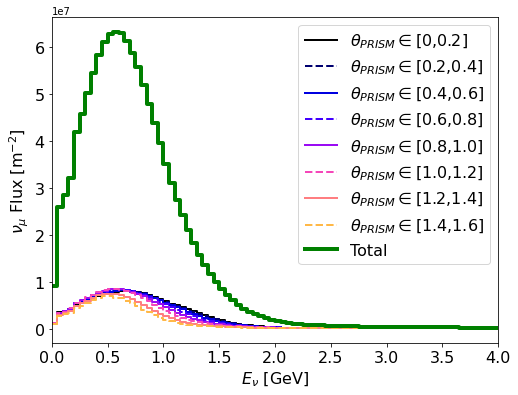

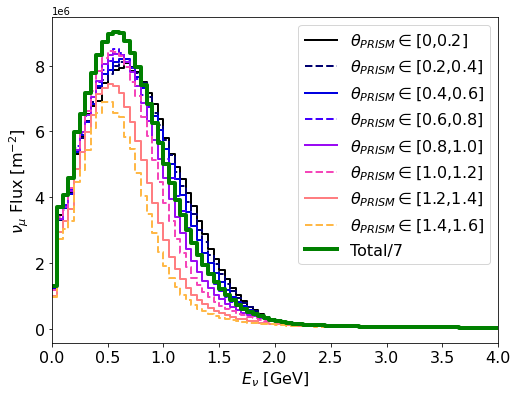

In [6]:
#Plot all fluxes on same plot
for j,dens in enumerate(['','_dens']):
  fig,ax = plt.subplots(figsize=(8,6))
  for i in range(len(PRISM_BINS)-2):
    makeplot.plot_hist_edges(hist_sbnd_fluxes_np[i][1]
                            ,hist_sbnd_fluxes_np[i][0]
                            ,None
                            ,PRISM_LABELS[i]
                            ,ax=ax
                            ,lw=2
                            ,color=PRISM_COLORS[i]
                            ,ls='-' if i % 2 == 0 else '--')
  if dens == '_dens':
    divide_by = 7
    total_label = 'Total/7'
  else:
    divide_by = 1
    total_label = 'Total'
  makeplot.plot_hist_edges(sbnd_flux[1],sbnd_flux[0]/divide_by,None,total_label,ax=ax,lw=4,color='green')
  ax.set_xlabel(r'$E_\nu$ [GeV]')
  ax.set_ylabel(r'$\nu_\mu$ Flux [m$^{-2}$]')
  ax.legend()
  ax.set_xlim([0,4])
  plotters.set_style(ax)
  if save_plots:
    plotters.save_plot(f'fluxes_prism{dens}',fig=fig,folder_name=PLOTS_DIR)
  if close_plots:
    plt.close(fig)

In [7]:
dfs_crpa[0].head()

final_mu_E  final_mu_px  final_mu_py  final_mu_pz  \
entry subentry                                                      
0     0           0.548669     0.346060     0.266354     0.314916   
      1           0.701469    -0.417889    -0.252208     0.492601   
      2           0.308352    -0.056811     0.253282     0.128599   
      3           2.053037    -0.400368     0.089006     2.008875   
      4           0.637271    -0.229834     0.415575     0.411612   

                initialnu_pdg  initialnu_E  initialnu_px  initialnu_py  \
entry subentry                                                           
0     0                    14     0.872992           0.0           0.0   
      1                    14     1.097527           0.0           0.0   
      2                    14     0.450725           0.0           0.0   
      3                    14     2.187117           0.0           0.0   
      4                    14     0.835042           0.0           0.0   

                initialnu_pz         xsecs  ...        Q2         W  \
entry subentry                              ...                       
0     0             0.872992  4.515747e-10  ...  0.396965  2.085032   
      1             1.097527  4.868164e-10  ...  0.447313  2.136919   
      2             0.450725  2.740070e-10  ...  0.150875  1.977399   
      3             2.187117  4.681088e-10  ...  0.182009  1.961588   
      4             0.835042  4.430701e-10  ...  0.365706  1.975685   

                final_mu_p  final_mu_theta         w  costheta        weight  \
entry subentry                                                                 
0     0           0.538400        0.946025  0.324323  0.584912  6.153709e-06   
      1           0.693466        0.780807  0.396058  0.710346  4.752405e-06   
      2           0.289684        1.110821  0.142374  0.443926  3.746181e-06   
      3           2.050316        0.201397  0.134080  0.979788  1.170070e-07   
      4           0.628451        0.856663  0.197771  0.654963  6.265313e-06   

                event_weight  costheta_bin  momentum_bin  
entry subentry                                            
0     0             0.478515             4             2  
      1             0.369549             5             2  
      2             0.291305             3             0  
      3             0.009099             8             8  
      4             0.487194             5             2  

[5 rows x 23 columns]

## Events by muon kinematics

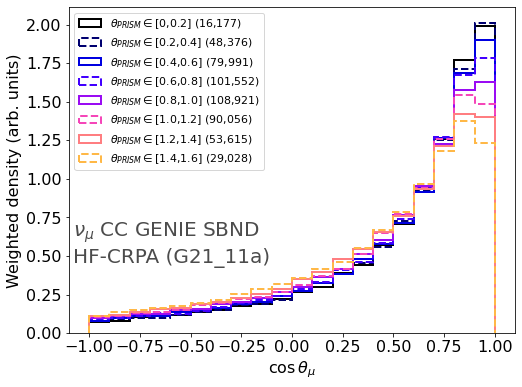

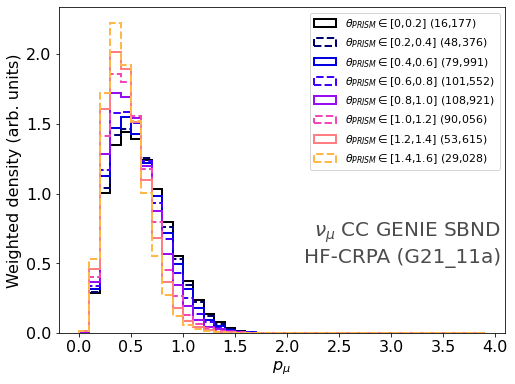

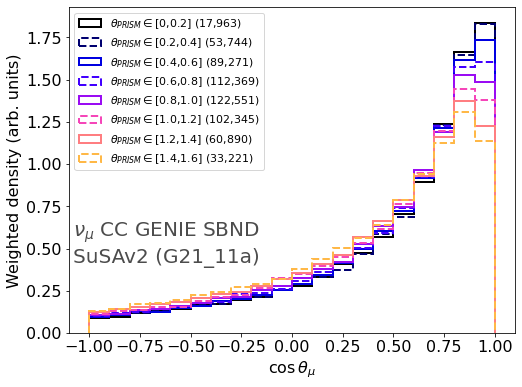

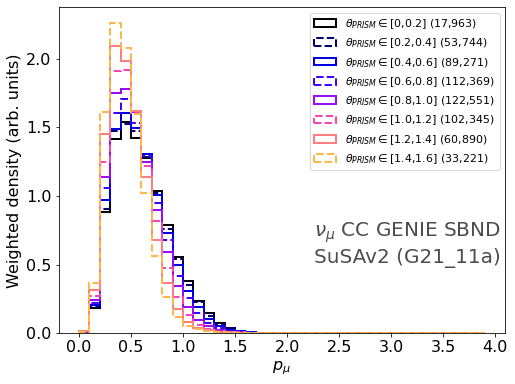

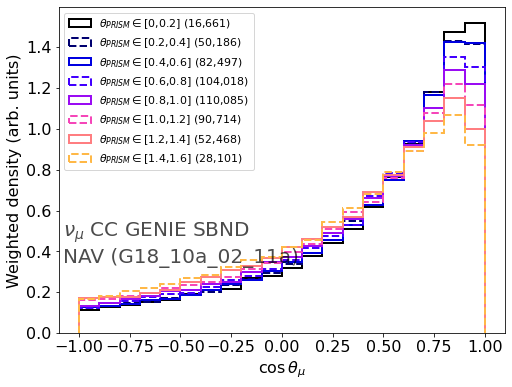

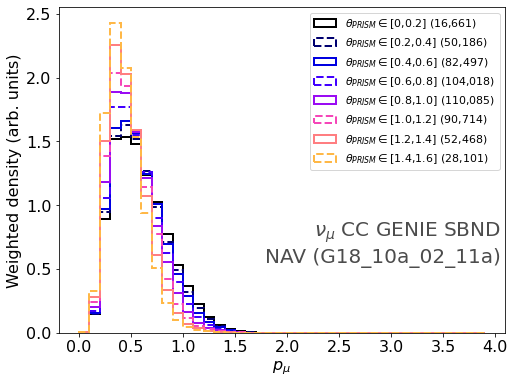

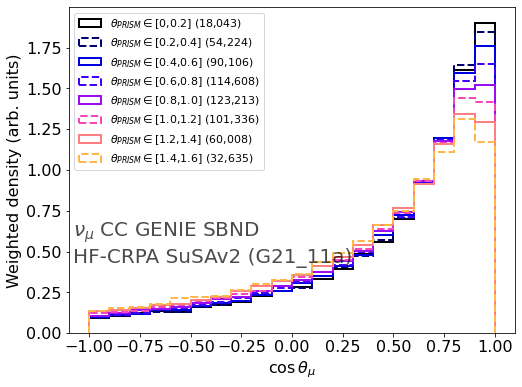

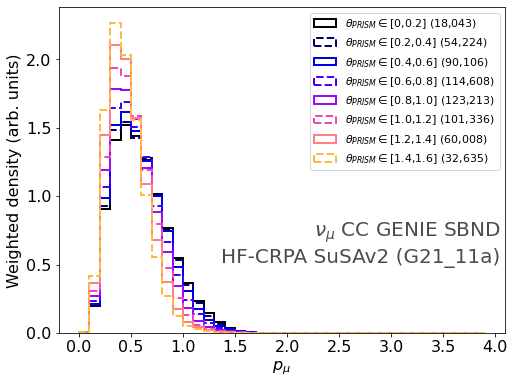

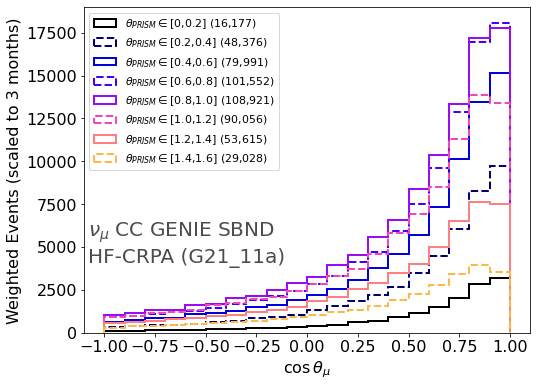

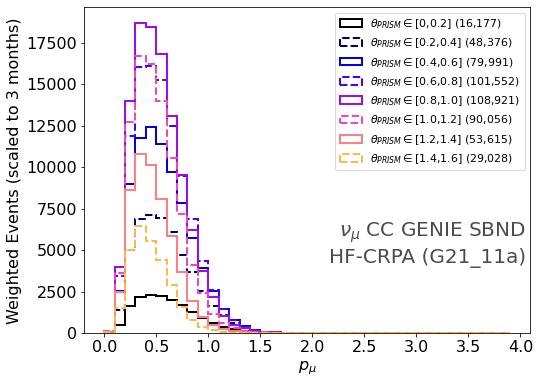

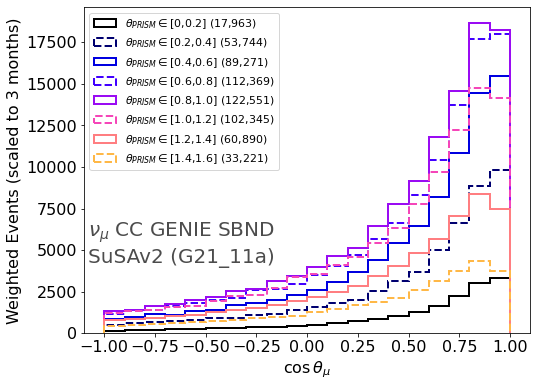

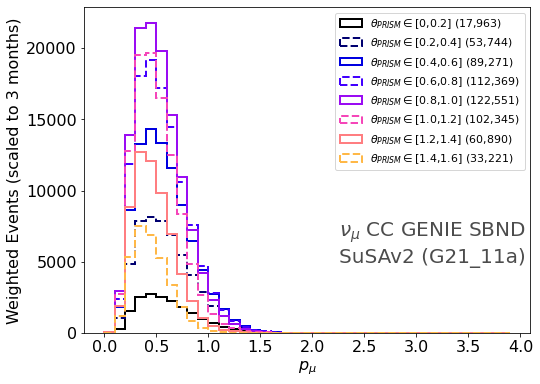

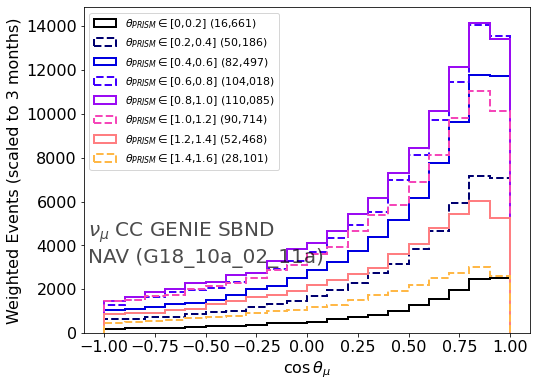

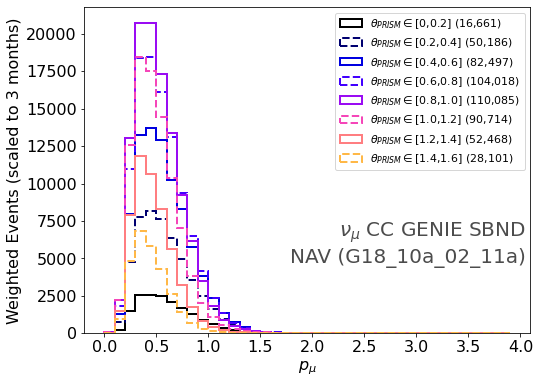

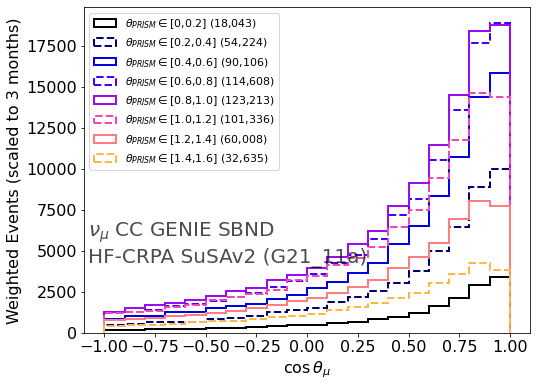

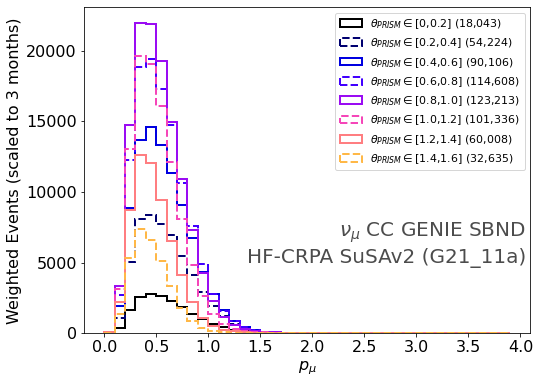

In [8]:
for k,dens in enumerate([True,False]):
  for i,df_list in enumerate(dfs_list):
    fig_costheta,ax_costheta = plt.subplots(figsize=(8,6))
    fig_momentum,ax_momentum = plt.subplots(figsize=(8,6))  

    costhetas = [df.costheta for df in df_list]
    momenta = [df.final_mu_p for df in df_list]
    weights = [df.event_weight for df in df_list]
    labels = [PRISM_LABELS[j] for j in range(len(PRISM_BINS)-2)]
    for j in range(len(costhetas)):
      labels[j] += f' ({round(np.sum(weights[j])):,})'
      ax_costheta.hist(costhetas[j],weights=weights[j]
              ,bins=np.arange(-1,1.1,0.1)
              ,label=labels[j]
              ,histtype='step'
              ,lw=2
              ,color=PRISM_COLORS[j]
              ,linestyle='-' if j % 2 == 0 else '--'
              ,density=dens)
      ax_momentum.hist(momenta[j],weights=weights[j]
              ,bins=np.arange(0,4,0.1)
              ,label=labels[j]
              ,histtype='step'
              ,lw=2
              ,color=PRISM_COLORS[j]
              ,linestyle='-' if j % 2 == 0 else '--'
              ,density=dens)
    for ax in [ax_costheta,ax_momentum]:
      ax.legend()
      if dens: 
        ax.set_ylabel('Weighted density (arb. units)')
      else:
        ax.set_ylabel('Weighted Events (scaled to 3 months)')
    plotters.set_style(ax_costheta,legend_size=11,legend_loc='upper left')
    plotters.add_label(ax_costheta,SIM_LABEL+'\n'+MODEL_LABELS[i],where='bottomishleft',fontsize=20,alpha=0.7)
    
    plotters.set_style(ax_momentum,legend_size=11,legend_loc='upper right')
    plotters.add_label(ax_momentum,SIM_LABEL+'\n'+MODEL_LABELS[i],where='bottomishright',fontsize=20,alpha=0.7)
    
    ax_costheta.set_xlabel(r'$\cos\theta_\mu$')
    ax_momentum.set_xlabel(r'$p_\mu$')
    if save_plots:
      if dens:
        suffix = f'_{MODEL_NAMES[i]}_dens'
      else:
        suffix = f'_{MODEL_NAMES[i]}'
      plotters.save_plot(f'costheta{suffix}',fig=fig_costheta,folder_name=PLOTS_DIR)
      plotters.save_plot(f'momentum{suffix}',fig=fig_momentum,folder_name=PLOTS_DIR)
    if close_plots:
      plt.close(fig_costheta)
      plt.close(fig_momentum)
  

## Ratio plot

In [93]:
#Set binning for costheta and momentum
costheta_bins_for_prism = COSTHETA_BINS.copy()
momentum_bins_for_prism = MOMENTUM_BINS.copy()

In [106]:
#Extract numpy histograms of data, weighted by event weight
costheta_hists_hybrid_all = [np.histogram(dfs_hybrid[i].costheta
                                      ,weights=dfs_hybrid[i].event_weight
                                      ,bins=costheta_bins_for_prism)\
                          for i in range(len(dfs_hybrid))]
costheta_hists_g21_all = [np.histogram(dfs_g21[i].costheta
                                      ,weights=dfs_g21[i].event_weight
                                      ,bins=costheta_bins_for_prism)\
                          for i in range(len(dfs_g21))]
costheta_hists_g18_all = [np.histogram(dfs_g18[i].costheta
                                      ,weights=dfs_g18[i].event_weight
                                      ,bins=costheta_bins_for_prism)\
                          for i in range(len(dfs_g18))]
costheta_hists_crpa_all = [np.histogram(dfs_crpa[i].costheta
                                      ,weights=dfs_crpa[i].event_weight
                                      ,bins=costheta_bins_for_prism)\
                          for i in range(len(dfs_crpa))]
costheta_counts_hybrid_all = np.sum([np.sum(dfs_hybrid[i].event_weight) for i in range(len(dfs_hybrid))])
costheta_counts_g21_all = np.sum([np.sum(dfs_g21[i].event_weight) for i in range(len(dfs_g21))])
costheta_counts_g18_all = np.sum([np.sum(dfs_g18[i].event_weight) for i in range(len(dfs_g18))])
costheta_counts_crpa_all = np.sum([np.sum(dfs_crpa[i].event_weight) for i in range(len(dfs_crpa))])

#Momentum
momentum_hists_hybrid_all = [np.histogram(dfs_hybrid[i].final_mu_p
                                      ,weights=dfs_hybrid[i].event_weight
                                      ,bins=momentum_bins_for_prism)\
                          for i in range(len(dfs_hybrid))]
momentum_hists_g21_all = [np.histogram(dfs_g21[i].final_mu_p
                                      ,weights=dfs_g21[i].event_weight
                                      ,bins=momentum_bins_for_prism)\
                          for i in range(len(dfs_g21))]
momentum_hists_g18_all = [np.histogram(dfs_g18[i].final_mu_p
                                      ,weights=dfs_g18[i].event_weight
                                      ,bins=momentum_bins_for_prism)\
                          for i in range(len(dfs_g18))]
momentum_hists_crpa_all = [np.histogram(dfs_crpa[i].final_mu_p
                                      ,weights=dfs_crpa[i].event_weight
                                      ,bins=momentum_bins_for_prism)\
                          for i in range(len(dfs_crpa))]
momentum_counts_hybrid_all = costheta_counts_hybrid_all
momentum_counts_g18_all = costheta_counts_g18_all
momentum_counts_g21_all = costheta_counts_g21_all
momentum_counts_crpa_all = costheta_counts_crpa_all


In [107]:
#Select specific bin to look at
costheta_bin = 8
momentum_bin = 2

#Extract numpy histograms of data, weighted by event weight
costheta_hists_hybrid = [np.histogram(dfs_hybrid[i][dfs_hybrid[i].momentum_bin == momentum_bin].costheta
                                      ,weights=dfs_hybrid[i][dfs_hybrid[i].momentum_bin == momentum_bin].event_weight
                                      ,bins=costheta_bins_for_prism)\
                          for i in range(len(dfs_hybrid))]
costheta_hists_g21 = [np.histogram(dfs_g21[i][dfs_g21[i].momentum_bin == momentum_bin].costheta
                                      ,weights=dfs_g21[i][dfs_g21[i].momentum_bin == momentum_bin].event_weight
                                      ,bins=costheta_bins_for_prism)\
                          for i in range(len(dfs_g21))]
costheta_hists_g18 = [np.histogram(dfs_g18[i][dfs_g18[i].momentum_bin == momentum_bin].costheta
                                      ,weights=dfs_g18[i][dfs_g18[i].momentum_bin == momentum_bin].event_weight
                                      ,bins=costheta_bins_for_prism)\
                          for i in range(len(dfs_g18))]
costheta_hists_crpa = [np.histogram(dfs_crpa[i][dfs_crpa[i].momentum_bin == momentum_bin].costheta
                                      ,weights=dfs_crpa[i][dfs_crpa[i].momentum_bin == momentum_bin].event_weight
                                      ,bins=costheta_bins_for_prism)\
                          for i in range(len(dfs_crpa))]
costheta_counts_hybrid = np.sum([np.sum(dfs_hybrid[i][dfs_hybrid[i].momentum_bin == momentum_bin].event_weight) for i in range(len(dfs_hybrid))])
costheta_counts_g21 = np.sum([np.sum(dfs_g21[i][dfs_g21[i].momentum_bin == momentum_bin].event_weight) for i in range(len(dfs_g21))])
costheta_counts_g18 = np.sum([np.sum(dfs_g18[i][dfs_g18[i].momentum_bin == momentum_bin].event_weight) for i in range(len(dfs_g18))])
costheta_counts_crpa = np.sum([np.sum(dfs_crpa[i][dfs_crpa[i].momentum_bin == momentum_bin].event_weight) for i in range(len(dfs_crpa))])

#Momentum
momentum_hists_hybrid = [np.histogram(dfs_hybrid[i][dfs_hybrid[i].costheta_bin == costheta_bin].final_mu_p
                                      ,weights=dfs_hybrid[i][dfs_hybrid[i].costheta_bin == costheta_bin].event_weight
                                      ,bins=momentum_bins_for_prism)\
                          for i in range(len(dfs_hybrid))]
momentum_hists_g21 = [np.histogram(dfs_g21[i][dfs_g21[i].costheta_bin == costheta_bin].final_mu_p
                                      ,weights=dfs_g21[i][dfs_g21[i].costheta_bin == costheta_bin].event_weight
                                      ,bins=momentum_bins_for_prism)\
                          for i in range(len(dfs_g21))]
momentum_hists_g18 = [np.histogram(dfs_g18[i][dfs_g18[i].costheta_bin == costheta_bin].final_mu_p
                                      ,weights=dfs_g18[i][dfs_g18[i].costheta_bin == costheta_bin].event_weight
                                      ,bins=momentum_bins_for_prism)\
                          for i in range(len(dfs_g18))]
momentum_hists_crpa = [np.histogram(dfs_crpa[i][dfs_g18[i].costheta_bin == costheta_bin].final_mu_p
                                      ,weights=dfs_crpa[i][dfs_g18[i].costheta_bin == costheta_bin].event_weight
                                      ,bins=momentum_bins_for_prism)\
                          for i in range(len(dfs_crpa))]
momentum_counts_hybrid = np.sum([np.sum(dfs_hybrid[i][dfs_hybrid[i].costheta_bin == costheta_bin].event_weight) for i in range(len(dfs_hybrid))])
momentum_counts_g21 = np.sum([np.sum(dfs_g21[i][dfs_g21[i].costheta_bin == costheta_bin].event_weight) for i in range(len(dfs_g21))])
momentum_counts_g18 = np.sum([np.sum(dfs_g18[i][dfs_g18[i].costheta_bin == costheta_bin].event_weight) for i in range(len(dfs_g18))])
momentum_counts_crpa = np.sum([np.sum(dfs_crpa[i][dfs_crpa[i].costheta_bin == costheta_bin].event_weight) for i in range(len(dfs_crpa))])

/tmp/ipykernel_26091/1081081766.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  momentum_hists_crpa = [np.histogram(dfs_crpa[i][dfs_g18[i].costheta_bin == costheta_bin].final_mu_p
/tmp/ipykernel_26091/1081081766.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ,weights=dfs_crpa[i][dfs_g18[i].costheta_bin == costheta_bin].event_weight


In [167]:
#Functions
def check_compatiblity_numpy_hists(hists1,hists2):
  """
  This function checks that two sets of histograms are compatible.
  Compatible means that they have the same number of histograms, the same number of bins, and the same number of values. 
  This function takes two sets of histograms as arguments and returns nothing.
  """
  assert len(hists1[0]) == len(hists2[0]), f'hists1 ({len(hists1[0])}) and hists2 ({len(hists2[0])}) must have same number of bins'
  assert len(hists1) == len(hists2), f'hists1 ({len(hists1)}) and hists2 ({len(hists2)}) must have same number of histograms'
  assert len(hists1[0][0]) == len(hists2[0][0]), f'hists1 ({len(hists1[0][0])}) and hists2 ({len(hists2[0][0])}) must have same number of values'
  assert len(hists1[0][1]) == len(hists2[0][1]), f'hists1 ({len(hists1[0][1])}) and hists2 ({len(hists2[0][1])}) must have same number of edges'
  assert len(hists1[0][0]) == len(hists1[0][1])-1, f'value array ({len(hists1[0][0])}) must be one less than edge array ({len(hists1[0][1])})'

def make_ratio_hist(num_hists, den_hists, numerator_coefficients, denominator_coefficients):
  """
  Compute the ratio of two sets of histograms.

  Parameters
  ----------
  num_hists : list of numpy arrays
    The numerator histograms.
  den_hists : list of numpy arrays
    The denominator histograms.
  numerator_coefficients : list of floats
    The coefficients to apply to each numerator histogram.
  denominator_coefficients : list of floats
    The coefficients to apply to each denominator histogram.

  Returns
  -------
  numpy array
    The ratio of the histograms.

  Raises
  ------
  AssertionError
    If the number of bins, histograms, or values in the histograms are not the same between num_hists and den_hists.

  Notes
  -----
  This function assumes that all histograms have the same bin edges.

  """
  check_compatiblity_numpy_hists(num_hists, den_hists)
  assert len(num_hists) == len(numerator_coefficients), f'numerator_coefficients ({len(numerator_coefficients)}) must be same length as num_hists ({len(num_hists)}) '
  assert len(den_hists) == len(denominator_coefficients), f'denominator_coefficients ({len(denominator_coefficients)}) must be same length as den_hists ({len(den_hists)}) '

  # initialize histograms
  numerator = np.zeros(len(num_hists[0][0]))
  denominator = numerator.copy()
  for i, num_hist in enumerate(num_hists):
    # Check for nonzero coefficient
    if numerator_coefficients[i] != 0:
      numerator += numerator_coefficients[i] * num_hist[0]
  for j, den_hist in enumerate(den_hists):
    # Check for nonzero coefficient
    if denominator_coefficients[j] != 0:
      denominator += denominator_coefficients[j] * den_hist[0]
  hist_ratio = numerator / denominator
  # Clean up nan and inf
  hist_ratio[np.isnan(hist_ratio)] = 0
  hist_ratio[np.isinf(hist_ratio)] = 0
  return hist_ratio

def make_diff_hist(hists, coefficients) -> np.ndarray:
  """
  Compute the weighted difference of multiple histograms.

  Parameters
  ----------
  hists : list of numpy arrays
    The histograms to be combined.
  coefficients : list of floats
    The coefficients to apply to each histogram.

  Returns
  -------
  numpy array
    The weighted difference of the histograms.

  Raises
  ------
  AssertionError
    If the number of bins or values in the histograms are not the same between hists.

  Notes
  -----
  This function assumes that all histograms have the same bin edges.

  """
  assert len(hists) == len(coefficients), f'coefficients ({len(coefficients)}) must be same length as hists ({len(hists)}) '
  check_compatiblity_numpy_hists(hists, hists)

  hist_diff = np.zeros(len(hists[0][0])) #initialize ratio histogram
  for i, hist in enumerate(hists):
    hist_diff += coefficients[i] * hist[0]
  if (hist_diff < 0).any():
    print('Warning: Negative values in difference histogram')
  return hist_diff

def write_flux_formula(coefficiencts):
  formula = ''
  term = 0
  for i,coeff in enumerate(coefficiencts):
    if coeff != 0:
      if term == 0:
        formula += f'{coeff}' + rf'$\phi_{i}$'
        term += 1
      else:
        if coeff > 0:
          formula += '+'
        else:
          formula += '-'
        formula += f'{abs(coeff)}' + rf'$\phi_{i}$'
        term += 1
  if formula == '': return formula
  while formula[-1] == '+' or formula[-1] == '-': #remove trailing + or -
    formula = formula[:-1]
  return formula
def make_prism_comparison_plots(numerator_coefficients,denominator_coefficients
                                ,model_comps,model_bin_edges,flux_ratios,sbnd_flux
                                ,model_labels,model_counts,model_colors,model_names
                                ,comp_model_ind=3,dE=0.05,xlabel='',comp_type='ratio'):
  """
  Make a set of four plots to compare PRISM ratios and fluxes for different models.

  Parameters
  ----------
  numerator_coefficients : list of floats
    The coefficients to apply to each numerator histogram.
  denominator_coefficients : list of floats or None
    The coefficients to apply to each denominator histogram. Set to None for diff comparison.
  model_comps : list of numpy arrays [n_models,n_bins,n_values]
    The PRISM ratios or differences for each model between the bins specified for flux combination.
  model_bin_edges : numpy array
    The bin edges for the PRISM ratios.
  flux_ratios : numpy array
    The flux ratios for each model.
  sbnd_flux : tuple of numpy arrays or None
    The flux for SBND, as a tuple of (flux, bin_edges), or None if not available.
  model_labels : list of strings
    The labels for each model.
  model_counts : list of integers
    The number of events for each model.
  model_colors : list of strings
    The colors to use for each model.
  model_names : list of strings
    The names of each model.
  comp_model_ind : int, optional
    The index of the model to use as the comparison model, by default 3.
  dE : float, optional
    The bin width for the histograms, by default 0.05.
  xlabel : str, optional
    The label for the x-axis, by default ''.
  comp_type : str, optional
    The type of comparison to make. Can be 'ratio' or 'diff', by default 'ratio'.

  Returns
  -------
  matplotlib.figure.Figure
    The figure containing the four plots.
  numpy.ndarray
    The axes for the four plots.

  Notes
  -----
  This function assumes that all histograms have the same bin edges.

  """

  print(f'-Numerator coefficients: {numerator_coefficients}')
  print(f'-Denominator coefficients: {denominator_coefficients}')
  print(f'-Comp model: {model_names[comp_model_ind]}')
  print(f'-Model names: {model_names}')
  print(f'-Model labels: {model_labels}')
  print(f'-Model colors: {model_colors}')

  
  #Write string corresponding to flux formula
  numerator_flux_formula = write_flux_formula(numerator_coefficients)
  if denominator_coefficients is not None:
    if comp_type == 'ratio':
      denominator_flux_formula = write_flux_formula(denominator_coefficients)
    else:
      print('Warning: denominator_coefficients is not None, but comp_type is not ratio. Setting denominator_flux_formula to empty string')
      denominator_flux_formula = ''
  else:
    if comp_type == 'ratio':
      print('Warning: denominator_coefficients is None, but comp_type is ratio. Setting denominator_flux_formula to empty string and comp_type to diff')
      denominator_flux_formula = ''
      comp_type = 'diff'
  
  #Compare flux ratio to flux by normalizing to flux for SBND
  if sbnd_flux is not None:
    flux_ratio_integral = np.sum(flux_ratios)*dE
    sbnd_flux_integral = np.sum(sbnd_flux[0])*dE
    sbnd_flux_comp = flux_ratio_integral/sbnd_flux_integral*sbnd_flux[0]
  
  #Make flux ratio plot
  fig, axs = plt.subplots(2, 2, figsize=(16, 10))
  ax_comparison, ax_flux, ax_diff, ax_weighted_diff = axs.flatten()
  comparison_axs = [ax_comparison,ax_diff,ax_weighted_diff]
  
  #Comparison ax
  for i,model_comp in enumerate(model_comps):
    makeplot.plot_hist_edges(model_bin_edges,model_comp,None
                            ,model_labels[i]+f' ({round(model_counts[i]):,})',ax=ax_comparison,lw=2,color=MODEL_COLORS[i])
  if comp_type == 'ratio':
    ax_comparison.set_ylabel('PRISM Ratio')
  elif comp_type == 'diff':
    ax_comparison.set_ylabel('PRISM Difference')
  else:
    raise ValueError(f'comp_type {comp_type} not recognized')
    
  
  #Flux ax
  makeplot.plot_hist_edges(sbnd_flux[1],flux_ratios,None,'PRISM Flux Ratio',ax=ax_flux,lw=3,color='black')
  if comp_type == 'ratio':
    if sbnd_flux is not None:
      makeplot.plot_hist_edges(sbnd_flux[1],sbnd_flux_comp,None,'Numerator Flux / SBND Flux (normalized)',ax=ax_flux,lw=2,ls='--',color='red')
    plotters.add_label(ax_flux,r'$\Phi=$'+numerator_flux_formula+'/'+denominator_flux_formula,where='toprightoutside',fontsize=20)
  elif comp_type == 'diff':
    if sbnd_flux is not None:
      makeplot.plot_hist_edges(sbnd_flux[1],sbnd_flux_comp,None,'SBND Flux (normalized)',ax=ax_flux,lw=2,ls='--',color='red')
    plotters.add_label(ax_flux,r'$\Phi=$'+numerator_flux_formula,where='toprightoutside',fontsize=20)
  ax_flux.set_xlabel(r'$E_\nu$ (GeV)')
  ax_flux.set_ylabel('Flux Combination')
  
  #difference axes
  for i,model_comp in enumerate(model_comps):
    if i == comp_model_ind: continue
    #Set values
    diff = model_comps[comp_model_ind]-model_comp
    diff_label = model_names[comp_model_ind]+' - '+model_names[i]
    
    weighted_diff = diff/model_comps[comp_model_ind]
    weighted_diff_label = '('+model_names[comp_model_ind]+' - '+model_names[i]+')'+' / '+model_names[comp_model_ind]
    #Weighted difference ax
    makeplot.plot_hist_edges(model_bin_edges,weighted_diff,None,weighted_diff_label,ax=ax_weighted_diff,lw=3,ls='-.',color=model_colors[i])
    
    #Difference ax
    makeplot.plot_hist_edges(model_bin_edges,diff,None,diff_label,ax=ax_diff,lw=3,ls='--',color=model_colors[i])
  ax_diff.axhline(0,ls=':',color='black')
  if comp_type == 'ratio':
    first_word = 'Ratio'
  elif comp_type == 'diff':
    first_word = 'Combination'
  else:
    first_word = 'NOOOOOOOOOOO'
  ax_diff.set_ylabel(f'{first_word} Difference')
  
  ax_weighted_diff.set_ylabel(f'Normalized {first_word} Difference')
  ax_weighted_diff.axhline(0,ls=':',color='black')
  for ax in comparison_axs:
    ax.set_xlabel(xlabel)
  for ax in axs.flatten():
    ax.grid()
  #Set a soft limit on the y-axis of the weighted difference plot
  min_weighted = max(ax_weighted_diff.get_ylim()[0],-1)
  max_weighted = min(ax_weighted_diff.get_ylim()[1],1)
  ax_weighted_diff.set_ylim([min_weighted,max_weighted])
  return fig,axs

In [168]:
#Coefficienct combos
sbnd_coeff = [1.,1.,1.,1.,1.,1.,1.,1.] #coefficients to get to sbnd flux
num_coeff_list = [
  [0.,1.,0.,0.,0.,0.,0.,0.] #fig 16
  ,[0.,0.,0.,1.,0.,0.,0.,0.] #fig 16
  ,[0.,0.,0.,0.,0.,1.,0.,0.] #fig 16
  ,[0.,0.,0.,0.,0.,0.,0.,1.] #fig 16
  
]
den_coeff_list = [
  [1.,0.,0.,0.,0.,0.,0.,0.] #fig 16
]
coeff1_list = [
  [-0.3,0.,0.,0.,0.,0.,0.,1.] #fig 2
  ,[1.,0.,0.,0.,0.,0.,0.,1.] #fig 3
  ,[-3.,-2.,-1.,0.,1.,2.,3.,4.] #my combo - tryna make sure it's positive
  ,[-2.,-1.,1.,1.,1.,1.,2.,3.] #my combo - sharpen that qe peak
]
test_num_coeff_list = [
  [0.,0.,0.,0.,0.,0.,0.,0.]
  ,sbnd_coeff
]
test_den_coeff_list = [
  [0.,0.,0.,0.,0.,0.,0.,0.]
  ,sbnd_coeff
]
test_coeff1_list = [
  [0.,0.,0.,0.,0.,0.,0.,0.]
  ,sbnd_coeff
]

In [169]:
save_plots

True

/tmp/ipykernel_26091/2726695999.py:59: RuntimeWarning: invalid value encountered in true_divide
  hist_ratio = numerator / denominator
/tmp/ipykernel_26091/2726695999.py:59: RuntimeWarning: divide by zero encountered in true_divide
  hist_ratio = numerator / denominator
/tmp/ipykernel_26091/2726695999.py:236: RuntimeWarning: invalid value encountered in true_divide
  weighted_diff = diff/model_comps[comp_model_ind]
/tmp/ipykernel_26091/2726695999.py:236: RuntimeWarning: divide by zero encountered in true_divide
  weighted_diff = diff/model_comps[comp_model_ind]
/tmp/ipykernel_26091/2726695999.py:236: RuntimeWarning: invalid value encountered in true_divide
  weighted_diff = diff/model_comps[comp_model_ind]


-Numerator coefficients: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
-Denominator coefficients: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
-Comp model: hybrid
-Model names: ['crpa', 'susav2', 'nav', 'hybrid']
-Model labels: ['HF-CRPA (G21_11a)', 'SuSAv2 (G21_11a)', 'NAV (G18_10a_02_11a)', 'HF-CRPA SuSAv2 (G21_11a)']
-Model colors: ['blue', 'orange', 'green', 'red']
**************************************************
-Numerator coefficients: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
-Denominator coefficients: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
-Comp model: hybrid
-Model names: ['crpa', 'susav2', 'nav', 'hybrid']
-Model labels: ['HF-CRPA (G21_11a)', 'SuSAv2 (G21_11a)', 'NAV (G18_10a_02_11a)', 'HF-CRPA SuSAv2 (G21_11a)']
-Model colors: ['blue', 'orange', 'green', 'red']
**************************************************
-Numerator coefficients: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
-Denominator coefficients: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
-Comp model: hybrid
-Model names: ['cr

/tmp/ipykernel_26091/2726695999.py:236: RuntimeWarning: invalid value encountered in true_divide
  weighted_diff = diff/model_comps[comp_model_ind]
/tmp/ipykernel_26091/2726695999.py:236: RuntimeWarning: divide by zero encountered in true_divide
  weighted_diff = diff/model_comps[comp_model_ind]
/tmp/ipykernel_26091/2726695999.py:236: RuntimeWarning: invalid value encountered in true_divide
  weighted_diff = diff/model_comps[comp_model_ind]


**************************************************
-Numerator coefficients: [-2.0, -1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 3.0]
-Denominator coefficients: None
-Comp model: hybrid
-Model names: ['crpa', 'susav2', 'nav', 'hybrid']
-Model labels: ['HF-CRPA (G21_11a)', 'SuSAv2 (G21_11a)', 'NAV (G18_10a_02_11a)', 'HF-CRPA SuSAv2 (G21_11a)']
-Model colors: ['blue', 'orange', 'green', 'red']
**************************************************
-Numerator coefficients: [-2.0, -1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 3.0]
-Denominator coefficients: None
-Comp model: hybrid
-Model names: ['crpa', 'susav2', 'nav', 'hybrid']
-Model labels: ['HF-CRPA (G21_11a)', 'SuSAv2 (G21_11a)', 'NAV (G18_10a_02_11a)', 'HF-CRPA SuSAv2 (G21_11a)']
-Model colors: ['blue', 'orange', 'green', 'red']
**************************************************
-Numerator coefficients: [-2.0, -1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 3.0]
-Denominator coefficients: None
-Comp model: hybrid
-Model names: ['crpa', 'susav2', 'nav', 'hybrid']
-Model labels: ['HF

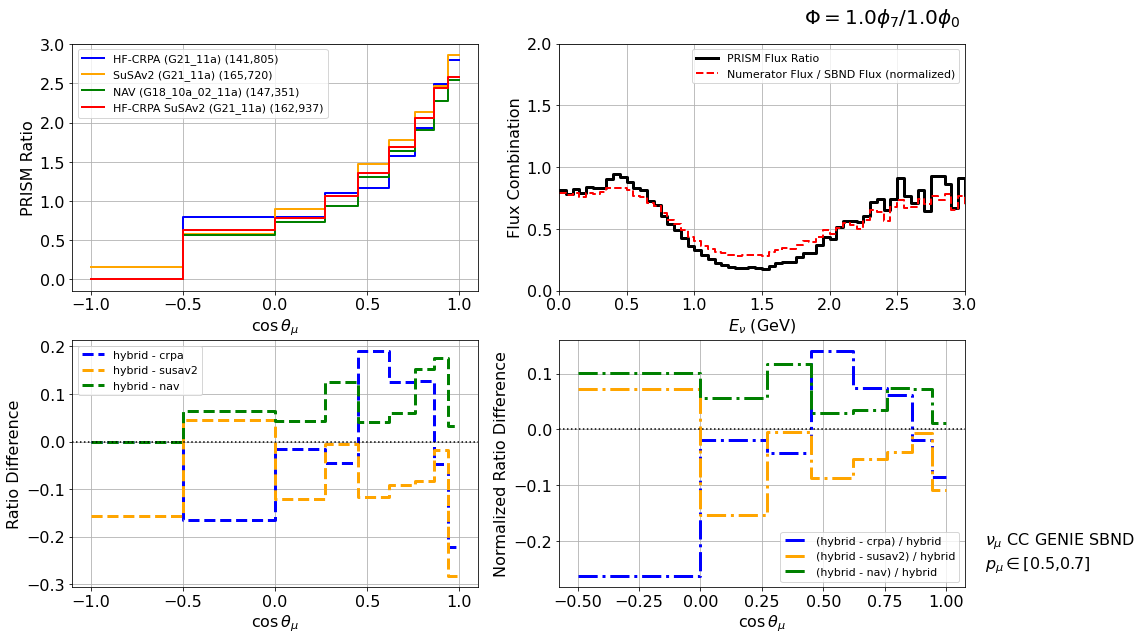

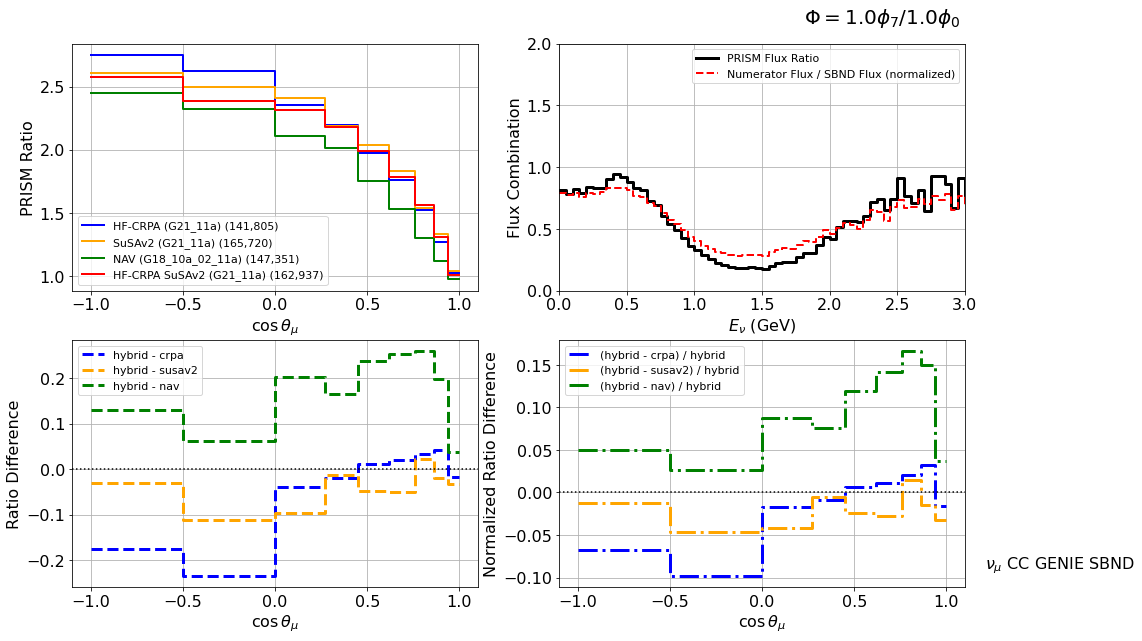

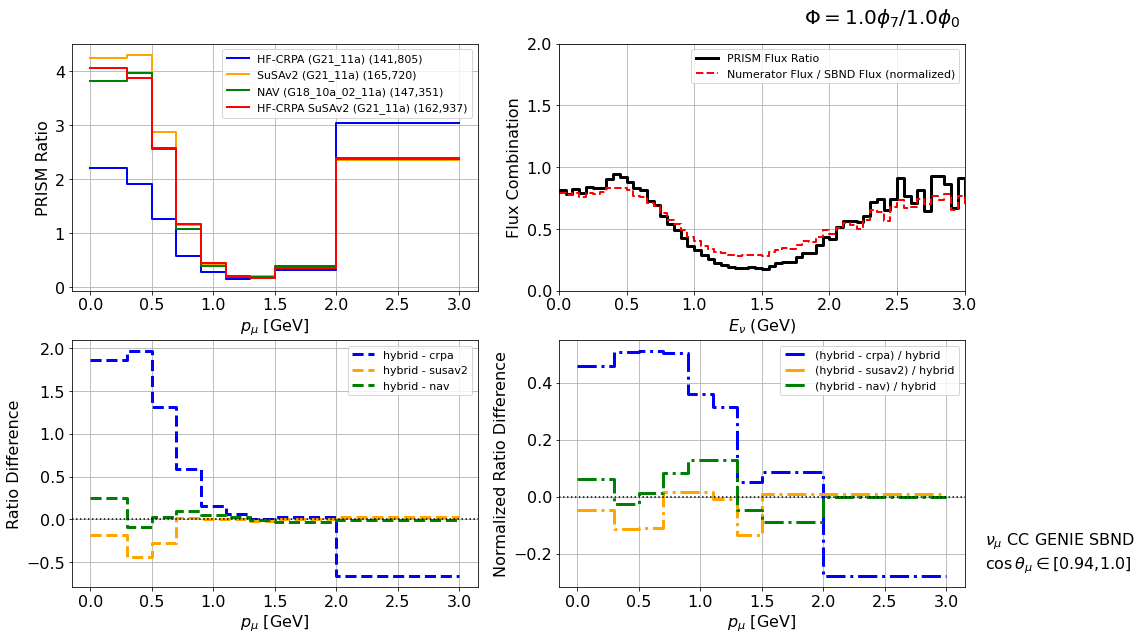

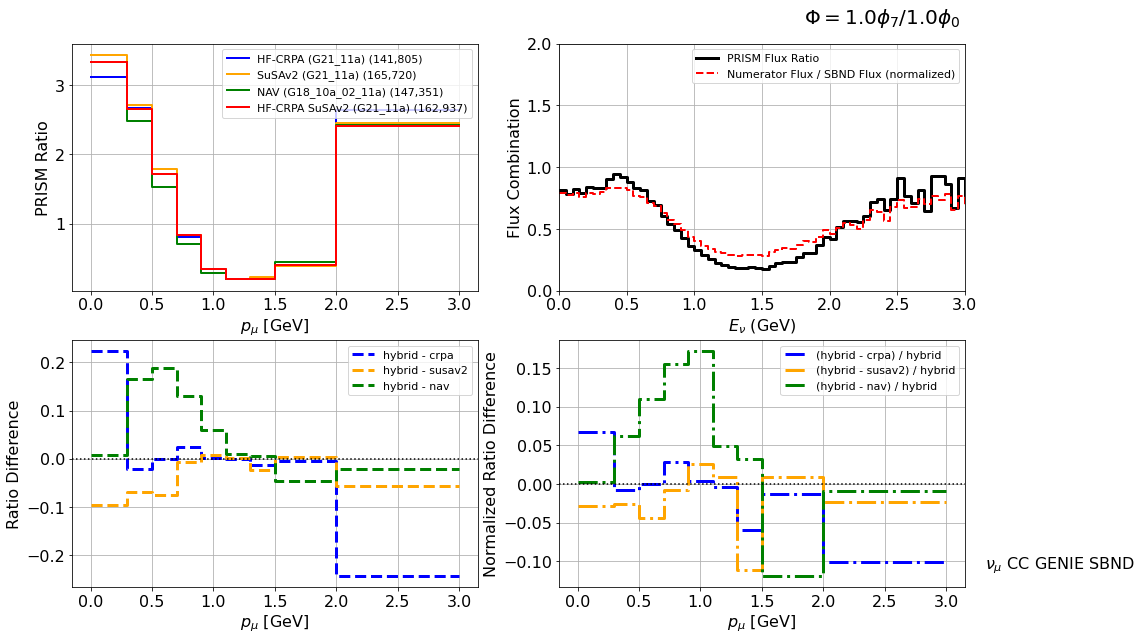

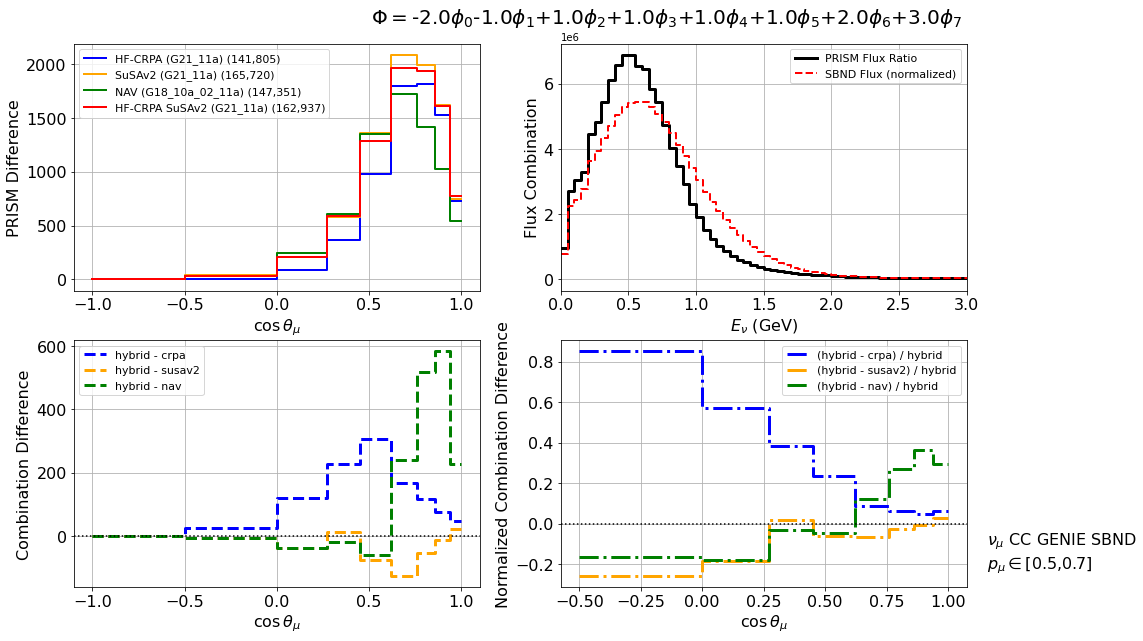

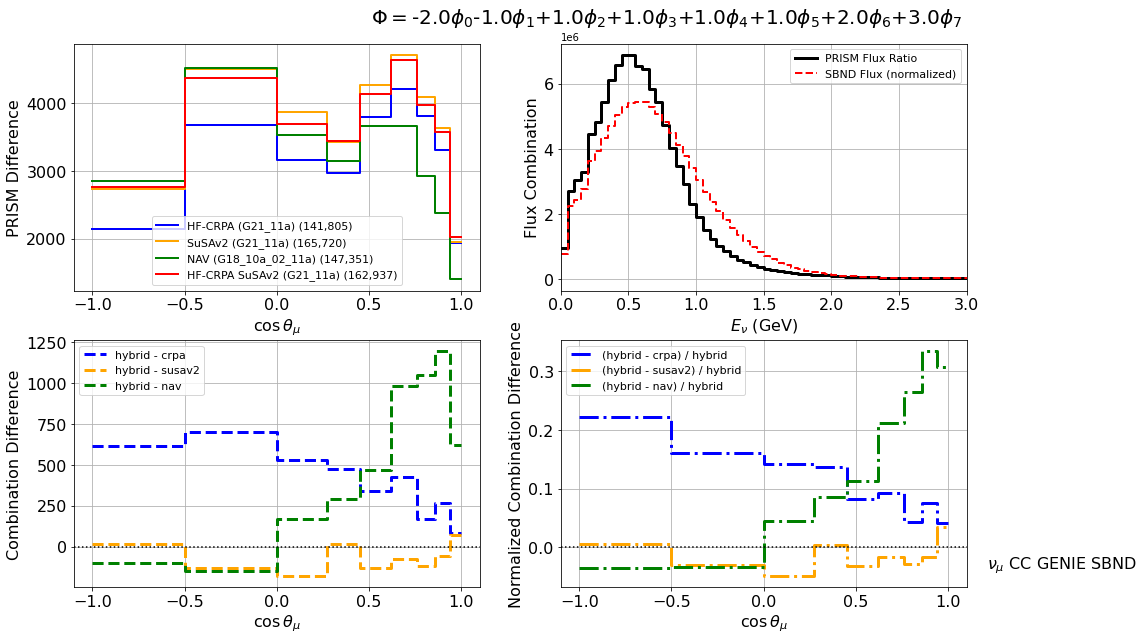

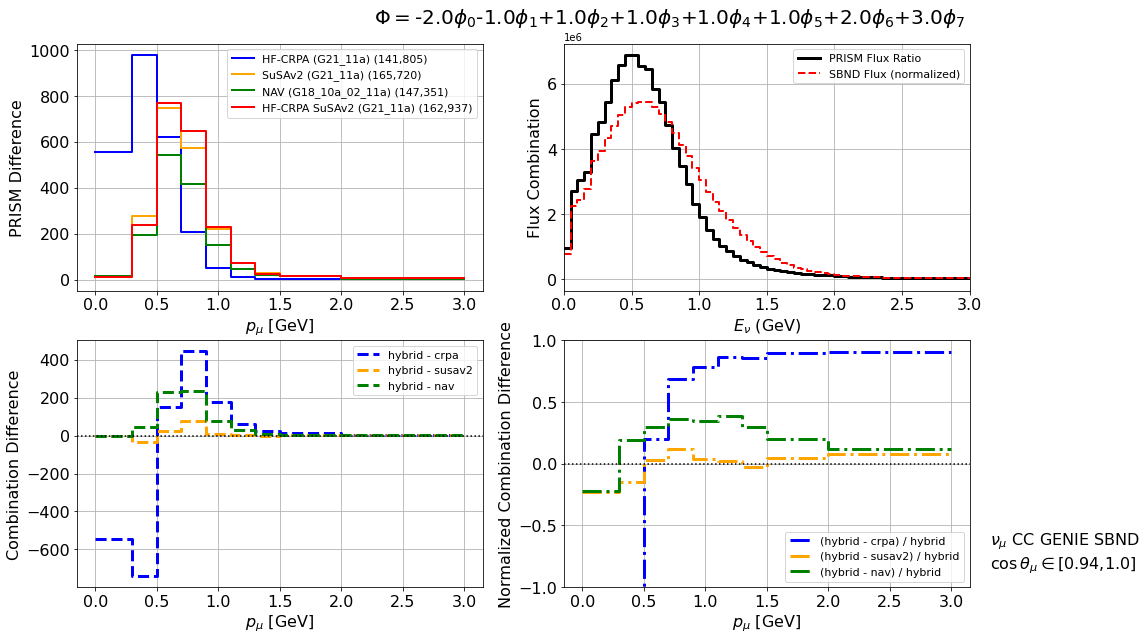

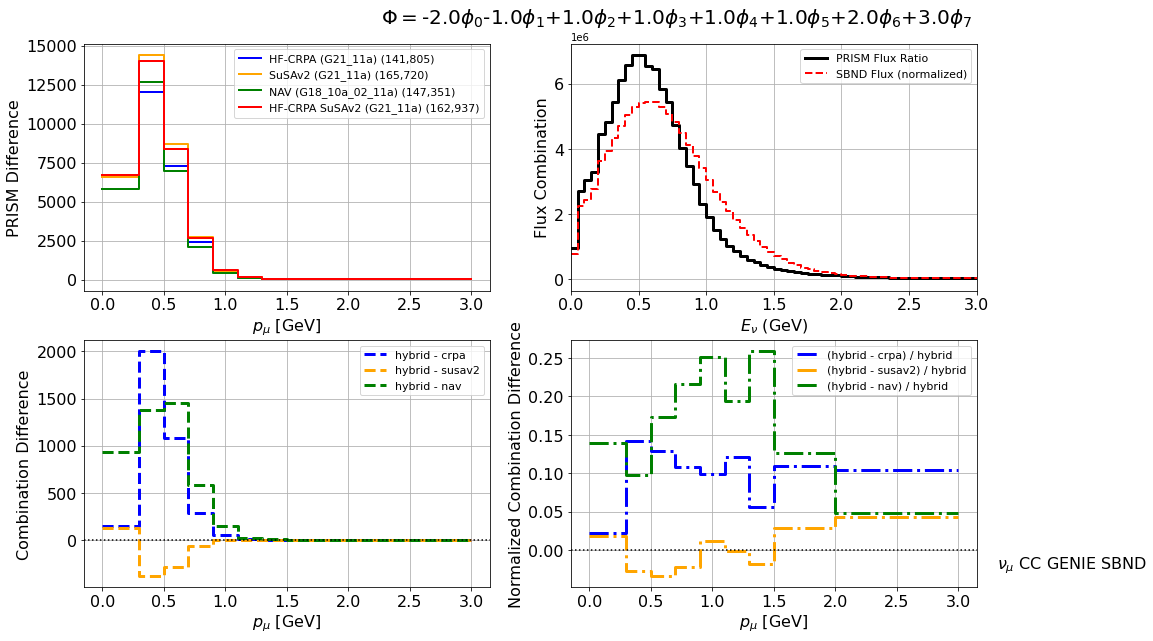

In [170]:
#Set up model inputs
plot_enum = 0 #iterate savename
sim_label_for_momentum_plot = SIM_LABEL + '\n' + r'$\cos\theta_\mu \in$'+f'[{COSTHETA_BINS[costheta_bin]},{COSTHETA_BINS[costheta_bin+1]}]'
sim_label_for_costheta_plot = SIM_LABEL + '\n' + r'$p_\mu \in$'+f'[{MOMENTUM_BINS[momentum_bin]},{MOMENTUM_BINS[momentum_bin+1]}]'

#Coefficients for flux combinations
num_coeff = num_coeff_list[3]
den_coeff = den_coeff_list[0]
coeff1 = coeff1_list[3]

#Get model info
model_costheta_hists = [costheta_hists_crpa,costheta_hists_g21,costheta_hists_g18,costheta_hists_hybrid]
model_costheta_counts = [costheta_counts_crpa,costheta_counts_g21,costheta_counts_g18,costheta_counts_hybrid]

model_costheta_hists_all = [costheta_hists_crpa_all,costheta_hists_g21_all,costheta_hists_g18_all,costheta_hists_hybrid_all]
model_costheta_counts_all = [costheta_counts_crpa_all,costheta_counts_g21_all,costheta_counts_g18_all,costheta_counts_hybrid_all]
costheta_bin_edges = costheta_hists_crpa[0][1]

model_momentum_hists = [momentum_hists_crpa,momentum_hists_g21,momentum_hists_g18,momentum_hists_hybrid]
model_momentum_counts = [momentum_counts_crpa,momentum_counts_g21,momentum_counts_g18,momentum_counts_hybrid]

model_momentum_hists_all = [momentum_hists_crpa_all,momentum_hists_g21_all,momentum_hists_g18_all,momentum_hists_hybrid_all]
model_momentum_counts_all = [momentum_counts_crpa_all,momentum_counts_g21_all,momentum_counts_g18_all,momentum_counts_hybrid_all]
momentum_bin_edges = momentum_hists_crpa[0][1]

#Ratios and differences
model_costheta_ratios = [make_ratio_hist(h,h,num_coeff,den_coeff) for h in model_costheta_hists]
model_costheta_diffs = [make_diff_hist(h,num_coeff) for h in model_costheta_hists]

model_costheta_all_ratios = [make_ratio_hist(h,h,num_coeff,den_coeff) for h in model_costheta_hists_all]
model_costheta_all_diffs = [make_diff_hist(h,num_coeff) for h in model_costheta_hists_all]

model_momentum_ratios = [make_ratio_hist(h,h,num_coeff,den_coeff) for h in model_momentum_hists]
model_momentum_diffs = [make_diff_hist(h,num_coeff) for h in model_momentum_hists]

model_momentum_all_ratios = [make_ratio_hist(h,h,num_coeff,den_coeff) for h in model_momentum_hists_all]
model_momentum_all_diffs = [make_diff_hist(h,num_coeff) for h in model_momentum_hists_all]

#Set up flux inputs
sbnd_flux_ratio = [make_ratio_hist(hist_sbnd_fluxes_np,hist_sbnd_fluxes_np,num_coeff,sbnd_coeff),sbnd_flux[1]] #ratio of combination to sbnd flux
flux_ratios = make_ratio_hist(hist_sbnd_fluxes_np,hist_sbnd_fluxes_np,num_coeff,den_coeff)
flux_diffs = make_diff_hist(hist_sbnd_fluxes_np,num_coeff)

#Ratio plots
fig,axs = make_prism_comparison_plots(num_coeff,den_coeff,model_costheta_ratios,costheta_bin_edges,flux_ratios,sbnd_flux_ratio
                                  ,MODEL_LABELS,model_counts,MODEL_COLORS,MODEL_NAMES
                                  ,xlabel=r'$\cos\theta_\mu$')
for i,ax in enumerate(axs.flatten()):
  ax.legend()
  plotters.set_style(ax,legend_size=11)
plotters.add_label(axs.flatten()[3],sim_label_for_costheta_plot,where='bottomrightoutside',fontsize=16)
axs.flatten()[1].set_xlim([0,3])
axs.flatten()[1].set_ylim([0,2])
if save_plots:
  plotters.save_plot(f'fluxes_prism_costheta_ratio_momentum_bin{momentum_bin}_number{plot_enum}',fig=fig,folder_name=PLOTS_DIR)
if close_plots:
  plt.close(fig)
print('*'*50)
fig,axs = make_prism_comparison_plots(num_coeff,den_coeff,model_costheta_all_ratios,costheta_bin_edges,flux_ratios,sbnd_flux_ratio
                                  ,MODEL_LABELS,model_counts,MODEL_COLORS,MODEL_NAMES
                                  ,xlabel=r'$\cos\theta_\mu$')
for i,ax in enumerate(axs.flatten()):
  ax.legend()
  plotters.set_style(ax,legend_size=11)
plotters.add_label(axs.flatten()[3],SIM_LABEL,where='bottomrightoutside',fontsize=16)
axs.flatten()[1].set_xlim([0,3])
axs.flatten()[1].set_ylim([0,2])
if save_plots:
  plotters.save_plot(f'fluxes_prism_costheta_ratio_number{plot_enum}',fig=fig,folder_name=PLOTS_DIR)
if close_plots:
  plt.close(fig)
print('*'*50)
fig,axs = make_prism_comparison_plots(num_coeff,den_coeff,model_momentum_ratios,momentum_bin_edges,flux_ratios,sbnd_flux_ratio
                                  ,MODEL_LABELS,model_counts,MODEL_COLORS,MODEL_NAMES
                                  ,xlabel=r'$p_\mu$ [GeV]')
for i,ax in enumerate(axs.flatten()):
  ax.legend()
  plotters.set_style(ax,legend_size=11)
plotters.add_label(axs.flatten()[3],sim_label_for_momentum_plot,where='bottomrightoutside',fontsize=16)
axs.flatten()[1].set_xlim([0,3])
axs.flatten()[1].set_ylim([0,2])
if save_plots:
  plotters.save_plot(f'fluxes_prism_momentum_ratio_costheta_bin{costheta_bin}_number{plot_enum}',fig=fig,folder_name=PLOTS_DIR)
if close_plots:
  plt.close(fig)
print('*'*50)
fig,axs = make_prism_comparison_plots(num_coeff,den_coeff,model_momentum_all_ratios,momentum_bin_edges,flux_ratios,sbnd_flux_ratio
                                  ,MODEL_LABELS,model_counts,MODEL_COLORS,MODEL_NAMES
                                  ,xlabel=r'$p_\mu$ [GeV]')
for i,ax in enumerate(axs.flatten()):
  ax.legend()
  plotters.set_style(ax,legend_size=11)
plotters.add_label(axs.flatten()[3],SIM_LABEL,where='bottomrightoutside',fontsize=16)
axs.flatten()[1].set_xlim([0,3])
axs.flatten()[1].set_ylim([0,2])
if save_plots:
  plotters.save_plot(f'fluxes_prism_momentum_ratio_number{plot_enum}',fig=fig,folder_name=PLOTS_DIR)
if close_plots:
  plt.close(fig)
print('*'*50)


#Diff plots
fig,axs = make_prism_comparison_plots(coeff1,None,model_costheta_diffs,costheta_bin_edges,flux_diffs,sbnd_flux
                                  ,MODEL_LABELS,model_counts,MODEL_COLORS,MODEL_NAMES
                                  ,xlabel=r'$\cos\theta_\mu$',comp_type='diff')
for i,ax in enumerate(axs.flatten()):
  ax.legend()
  plotters.set_style(ax,legend_size=11)
plotters.add_label(axs.flatten()[3],sim_label_for_costheta_plot,where='bottomrightoutside',fontsize=16)
axs.flatten()[1].set_xlim([0,3])
if save_plots:
  plotters.save_plot(f'fluxes_prism_costheta_diff_momentum_bin{momentum_bin}_number{plot_enum}',fig=fig,folder_name=PLOTS_DIR)
if close_plots:
  plt.close(fig)
print('*'*50)
fig,axs = make_prism_comparison_plots(coeff1,None,model_costheta_all_diffs,costheta_bin_edges,flux_diffs,sbnd_flux
                                  ,MODEL_LABELS,model_counts,MODEL_COLORS,MODEL_NAMES
                                  ,xlabel=r'$\cos\theta_\mu$',comp_type='diff')
for i,ax in enumerate(axs.flatten()):
  ax.legend()
  plotters.set_style(ax,legend_size=11)
plotters.add_label(axs.flatten()[3],SIM_LABEL,where='bottomrightoutside',fontsize=16)
axs.flatten()[1].set_xlim([0,3])
if save_plots:
  plotters.save_plot(f'fluxes_prism_costheta_diff_number{plot_enum}',fig=fig,folder_name=PLOTS_DIR)
if close_plots:
  plt.close(fig)
print('*'*50)
fig,axs = make_prism_comparison_plots(coeff1,None,model_momentum_diffs,momentum_bin_edges,flux_diffs,sbnd_flux
                                  ,MODEL_LABELS,model_counts,MODEL_COLORS,MODEL_NAMES
                                  ,xlabel=r'$p_\mu$ [GeV]',comp_type='diff')
for i,ax in enumerate(axs.flatten()):
  ax.legend()
  plotters.set_style(ax,legend_size=11)
plotters.add_label(axs.flatten()[3],sim_label_for_momentum_plot,where='bottomrightoutside',fontsize=16)
axs.flatten()[1].set_xlim([0,3])
if save_plots:
  plotters.save_plot(f'fluxes_prism_momentum_diff_costheta_bin{costheta_bin}_number{plot_enum}',fig=fig,folder_name=PLOTS_DIR)
if close_plots:
  plt.close(fig)
print('*'*50)
fig,axs = make_prism_comparison_plots(coeff1,None,model_momentum_all_diffs,momentum_bin_edges,flux_diffs,sbnd_flux
                                  ,MODEL_LABELS,model_counts,MODEL_COLORS,MODEL_NAMES
                                  ,xlabel=r'$p_\mu$ [GeV]',comp_type='diff')
for i,ax in enumerate(axs.flatten()):
  ax.legend()
  plotters.set_style(ax,legend_size=11)
plotters.add_label(axs.flatten()[3],SIM_LABEL,where='bottomrightoutside',fontsize=16)
axs.flatten()[1].set_xlim([0,3])
if save_plots:
  plotters.save_plot(f'fluxes_prism_momentum_diff_number{plot_enum}',fig=fig,folder_name=PLOTS_DIR)
if close_plots:
  plt.close(fig)
print('*'*50)

/tmp/ipykernel_26091/970081297.py:58: RuntimeWarning: invalid value encountered in true_divide
  hist_ratio = numerator / denominator
/tmp/ipykernel_26091/970081297.py:58: RuntimeWarning: divide by zero encountered in true_divide
  hist_ratio = numerator / denominator
/tmp/ipykernel_26091/2536328401.py:77: RuntimeWarning: invalid value encountered in true_divide
  ,(hybrid_ratios-crpa_ratios)/hybrid_ratios
/tmp/ipykernel_26091/2536328401.py:85: RuntimeWarning: divide by zero encountered in true_divide
  ,(hybrid_ratios-g21_ratios)/hybrid_ratios
/tmp/ipykernel_26091/2536328401.py:85: RuntimeWarning: invalid value encountered in true_divide
  ,(hybrid_ratios-g21_ratios)/hybrid_ratios
/tmp/ipykernel_26091/2536328401.py:93: RuntimeWarning: invalid value encountered in true_divide
  ,(hybrid_ratios-g18_ratios)/hybrid_ratios


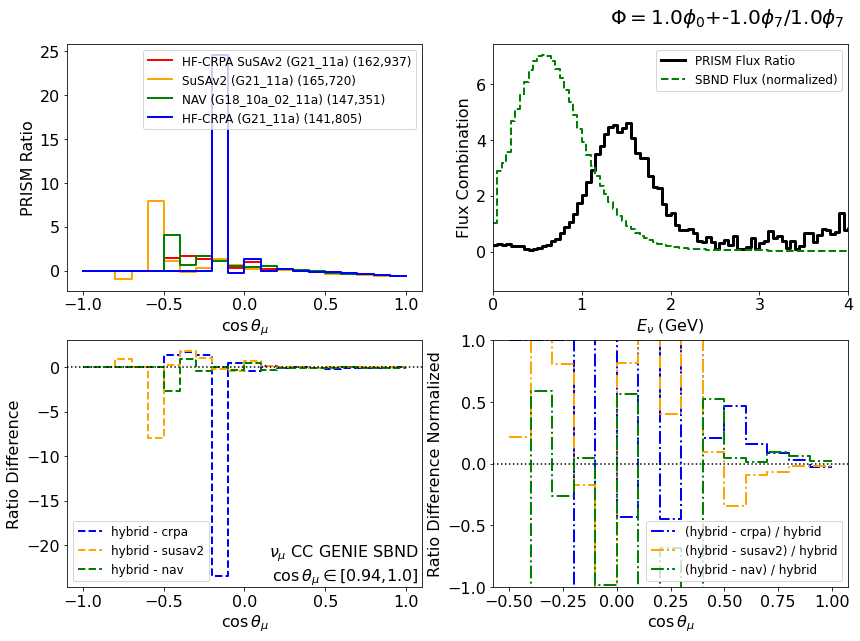

In [31]:
#Ratio plots
numerator_coefficients = [1.,0.,0.,0.,0.,0.,0.,-1.]
numerator_flux_formula = write_flux_formula(numerator_coefficients)

denominator_coefficients = [0.,0.,0.,0.,0.,0.,0.,1.]
denominator_flux_formula = write_flux_formula(denominator_coefficients)

hybrid_ratios = make_ratio_hist(costheta_hists_hybrid,costheta_hists_hybrid,numerator_coefficients,denominator_coefficients)
g21_ratios = make_ratio_hist(costheta_hists_g21,costheta_hists_g21,numerator_coefficients,denominator_coefficients)
g18_ratios = make_ratio_hist(costheta_hists_g18,costheta_hists_g18,numerator_coefficients,denominator_coefficients)
crpa_ratios = make_ratio_hist(costheta_hists_crpa,costheta_hists_crpa,numerator_coefficients,denominator_coefficients)
flux_ratios = make_ratio_hist(hist_sbnd_fluxes_np,hist_sbnd_fluxes_np,numerator_coefficients,denominator_coefficients)

#Compare flux ratio to flux
flux_ratio_integral = np.sum(flux_ratios)*dE
sbnd_flux_integral = np.sum(sbnd_flux[0])*dE
sbnd_flux_comp = flux_ratio_integral/sbnd_flux_integral*sbnd_flux[0]

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
ax_costheta, ax_flux, ax_diff, ax_weighted_diff = axs.flatten()
costheta_axs = [ax_costheta,ax_diff,ax_weighted_diff]

#Cos theta ax
makeplot.plot_hist_edges(costheta_hists_hybrid[0][1],hybrid_ratios,None
                         ,HYBRID_LABEL+f' ({round(costheta_counts_hybrid):,})',ax=ax_costheta,lw=2,color=MODEL_COLORS[3])
makeplot.plot_hist_edges(costheta_hists_hybrid[0][1],g21_ratios,None
                         ,G21_LABEL+f' ({round(costheta_counts_g21):,})',ax=ax_costheta,lw=2,color=MODEL_COLORS[1])
makeplot.plot_hist_edges(costheta_hists_hybrid[0][1],g18_ratios,None
                         ,G18_LABEL+f' ({round(costheta_counts_g18):,})',ax=ax_costheta,lw=2,color=MODEL_COLORS[2])
makeplot.plot_hist_edges(costheta_hists_hybrid[0][1],crpa_ratios,None
                         ,CRPA_LABEL+f' ({round(costheta_counts_crpa):,})',ax=ax_costheta,lw=2,color=MODEL_COLORS[0])
ax_costheta.set_ylabel('PRISM Ratio')


#Flux ax
makeplot.plot_hist_edges(hist_sbnd_fluxes_np[0][1],flux_ratios,None,'PRISM Flux Ratio',ax=ax_flux,lw=3,color='black')
makeplot.plot_hist_edges(sbnd_flux[1],sbnd_flux_comp,None,'SBND Flux (normalized)',ax=ax_flux,lw=2,ls='--',color='green')
ax_flux.set_xlim([0,4])
plotters.add_label(ax_flux,r'$\Phi=$'+numerator_flux_formula+'/'+denominator_flux_formula,where='toprightoutside',fontsize=20)
ax_flux.set_xlabel(r'$E_\nu$ (GeV)')
ax_flux.set_ylabel('Flux Combination')


#Diff ax
makeplot.plot_hist_edges(costheta_hists_hybrid[0][1]
                         ,hybrid_ratios-crpa_ratios
                         ,None
                         ,MODEL_NAMES[3]+' - '+MODEL_NAMES[0]
                         ,ax=ax_diff
                         ,lw=2
                         ,ls='--'
                         ,color=MODEL_COLORS[0])
makeplot.plot_hist_edges(costheta_hists_hybrid[0][1]
                         ,hybrid_ratios-g21_ratios
                         ,None
                         ,MODEL_NAMES[3]+' - '+MODEL_NAMES[1]
                         ,ax=ax_diff
                         ,lw=2
                         ,ls='--'
                         ,color=MODEL_COLORS[1])
makeplot.plot_hist_edges(costheta_hists_hybrid[0][1]
                         ,hybrid_ratios-g18_ratios
                         ,None
                         ,MODEL_NAMES[3]+' - '+MODEL_NAMES[2]
                         ,ax=ax_diff
                         ,lw=2
                         ,ls='--'
                         ,color=MODEL_COLORS[2])
ax_diff.axhline(0,ls=':',color='black')
ax_diff.set_ylabel('Ratio Difference')
plotters.add_label(ax_diff
                   ,SIM_LABEL+'\n'+r'$\cos\theta_\mu \in$'+f'[{COSTHETA_BINS[costheta_bin]},{COSTHETA_BINS[costheta_bin+1]}]'
                   ,where='bottomright',fontsize=16)

#Weighted diff ax
makeplot.plot_hist_edges(costheta_hists_hybrid[0][1]
                         ,(hybrid_ratios-crpa_ratios)/hybrid_ratios
                         ,None
                         ,'('+MODEL_NAMES[3]+' - '+MODEL_NAMES[0]+')'+f' / {MODEL_NAMES[3]}'
                         ,ax=ax_weighted_diff
                         ,lw=2
                         ,ls='-.'
                         ,color=MODEL_COLORS[0])
makeplot.plot_hist_edges(costheta_hists_hybrid[0][1]
                         ,(hybrid_ratios-g21_ratios)/hybrid_ratios
                         ,None
                         ,'('+MODEL_NAMES[3]+' - '+MODEL_NAMES[1]+')'+f' / {MODEL_NAMES[3]}'
                         ,ax=ax_weighted_diff
                         ,lw=2
                         ,ls='-.'
                         ,color=MODEL_COLORS[1])
makeplot.plot_hist_edges(costheta_hists_hybrid[0][1]
                         ,(hybrid_ratios-g18_ratios)/hybrid_ratios
                         ,None
                         ,'('+MODEL_NAMES[3]+' - '+MODEL_NAMES[2]+')'+f' / {MODEL_NAMES[3]}'
                         ,ax=ax_weighted_diff
                         ,lw=2
                         ,ls='-.'
                         ,color=MODEL_COLORS[2])
ax_weighted_diff.set_ylabel('Ratio Difference Normalized')
ax_weighted_diff.axhline(0,ls=':',color='black')
ax_weighted_diff.set_ylim([-1,1])

for ax in costheta_axs:
  ax.set_xlabel(r'$\cos\theta_\mu$')
for ax in axs.flatten():
  ax.legend()
  plotters.set_style(ax,legend_size=12)
if save_plots:
  #plotters.save_plot(f'prism_ratio_comp_costheta',fig=fig,folder_name=PLOTS_DIR,overwrite=False)
  tt=0
if close_plots:
  plt.close(fig)

/tmp/ipykernel_26091/2361464451.py:75: RuntimeWarning: invalid value encountered in true_divide
  ,(hybrid_diffs-crpa_diffs)/hybrid_diffs
/tmp/ipykernel_26091/2361464451.py:83: RuntimeWarning: divide by zero encountered in true_divide
  ,(hybrid_diffs-g21_diffs)/hybrid_diffs
/tmp/ipykernel_26091/2361464451.py:83: RuntimeWarning: invalid value encountered in true_divide
  ,(hybrid_diffs-g21_diffs)/hybrid_diffs
/tmp/ipykernel_26091/2361464451.py:91: RuntimeWarning: invalid value encountered in true_divide
  ,(hybrid_diffs-g18_diffs)/hybrid_diffs


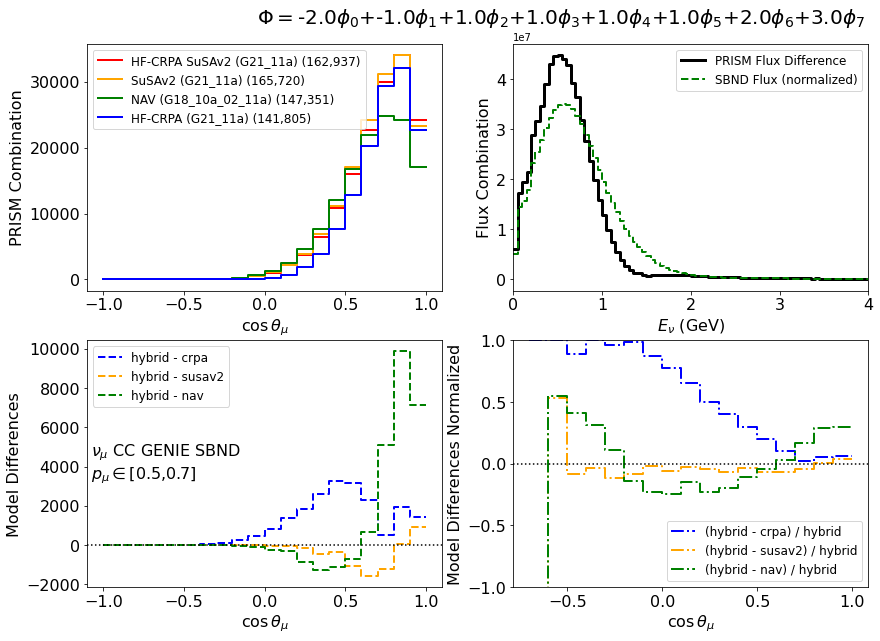

In [24]:
#Diff plots
coefficiencts1 = [-2.,-1.,1.,1.,1.,1.,2.,3.]
coefficiencts1_flux_formula = write_flux_formula(coefficiencts1)

hybrid_diffs = make_diff_hist(costheta_hists_hybrid,coefficiencts1)
g21_diffs = make_diff_hist(costheta_hists_g21,coefficiencts1)
g18_diffs = make_diff_hist(costheta_hists_g18,coefficiencts1)
crpa_diffs = make_diff_hist(costheta_hists_crpa,coefficiencts1)
flux_diffs = make_diff_hist(hist_sbnd_fluxes_np,coefficiencts1)

#Compare flux diff to flux
flux_diff_integral = np.sum(flux_diffs)*dE
sbnd_flux_integral = np.sum(sbnd_flux[0])*dE
sbnd_flux_comp = flux_diff_integral/sbnd_flux_integral*sbnd_flux[0]

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
ax_costheta, ax_flux, ax_diff, ax_weighted_diff = axs.flatten()
costheta_axs = [ax_costheta,ax_diff,ax_weighted_diff]

#Cos theta ax
makeplot.plot_hist_edges(costheta_hists_hybrid[0][1],hybrid_diffs,None
                         ,HYBRID_LABEL+f' ({round(costheta_counts_hybrid):,})',ax=ax_costheta,lw=2,color=MODEL_COLORS[3])
makeplot.plot_hist_edges(costheta_hists_hybrid[0][1],g21_diffs,None
                         ,G21_LABEL+f' ({round(costheta_counts_g21):,})',ax=ax_costheta,lw=2,color=MODEL_COLORS[1])
makeplot.plot_hist_edges(costheta_hists_hybrid[0][1],g18_diffs,None
                         ,G18_LABEL+f' ({round(costheta_counts_g18):,})',ax=ax_costheta,lw=2,color=MODEL_COLORS[2])
makeplot.plot_hist_edges(costheta_hists_hybrid[0][1],crpa_diffs,None
                         ,CRPA_LABEL+f' ({round(costheta_counts_crpa):,})',ax=ax_costheta,lw=2,color=MODEL_COLORS[0])
ax_costheta.set_ylabel('PRISM Combination')


#Flux ax
makeplot.plot_hist_edges(hist_sbnd_fluxes_np[0][1],flux_diffs,None,'PRISM Flux Difference',ax=ax_flux,lw=3,color='black')
makeplot.plot_hist_edges(sbnd_flux[1],sbnd_flux_comp,None,'SBND Flux (normalized)',ax=ax_flux,lw=2,ls='--',color='green')
ax_flux.set_xlim([0,4])
coeff_string = coefficiencts1_flux_formula
plotters.add_label(ax_flux,r'$\Phi=$'+coeff_string,where='toprightoutside',fontsize=20)
ax_flux.set_xlabel(r'$E_\nu$ (GeV)')
ax_flux.set_ylabel('Flux Combination')


#Diff ax
makeplot.plot_hist_edges(costheta_hists_hybrid[0][1]
                         ,hybrid_diffs-crpa_diffs
                         ,None
                         ,MODEL_NAMES[3]+' - '+MODEL_NAMES[0]
                         ,ax=ax_diff
                         ,lw=2
                         ,ls='--'
                         ,color=MODEL_COLORS[0])
makeplot.plot_hist_edges(costheta_hists_hybrid[0][1]
                         ,hybrid_diffs-g21_diffs
                         ,None
                         ,MODEL_NAMES[3]+' - '+MODEL_NAMES[1]
                         ,ax=ax_diff
                         ,lw=2
                         ,ls='--'
                         ,color=MODEL_COLORS[1])
makeplot.plot_hist_edges(costheta_hists_hybrid[0][1]
                         ,hybrid_diffs-g18_diffs
                         ,None
                         ,MODEL_NAMES[3]+' - '+MODEL_NAMES[2]
                         ,ax=ax_diff
                         ,lw=2
                         ,ls='--'
                         ,color=MODEL_COLORS[2])
ax_diff.axhline(0,ls=':',color='black')
ax_diff.set_ylabel('Model Differences')
plotters.add_label(ax_diff
                   ,SIM_LABEL+'\n'+r'$p_\mu \in$'+f'[{MOMENTUM_BINS[momentum_bin]},{MOMENTUM_BINS[momentum_bin+1]}]'
                   ,where='centerleft',fontsize=16)

#Weighted diff ax
makeplot.plot_hist_edges(costheta_hists_hybrid[0][1]
                         ,(hybrid_diffs-crpa_diffs)/hybrid_diffs
                         ,None
                         ,'('+MODEL_NAMES[3]+' - '+MODEL_NAMES[0]+')'+f' / {MODEL_NAMES[3]}'
                         ,ax=ax_weighted_diff
                         ,lw=2
                         ,ls='-.'
                         ,color=MODEL_COLORS[0])
makeplot.plot_hist_edges(costheta_hists_hybrid[0][1]
                         ,(hybrid_diffs-g21_diffs)/hybrid_diffs
                         ,None
                         ,'('+MODEL_NAMES[3]+' - '+MODEL_NAMES[1]+')'+f' / {MODEL_NAMES[3]}'
                         ,ax=ax_weighted_diff
                         ,lw=2
                         ,ls='-.'
                         ,color=MODEL_COLORS[1])
makeplot.plot_hist_edges(costheta_hists_hybrid[0][1]
                         ,(hybrid_diffs-g18_diffs)/hybrid_diffs
                         ,None
                         ,'('+MODEL_NAMES[3]+' - '+MODEL_NAMES[2]+')'+f' / {MODEL_NAMES[3]}'
                         ,ax=ax_weighted_diff
                         ,lw=2
                         ,ls='-.'
                         ,color=MODEL_COLORS[2])
ax_weighted_diff.set_ylabel('Model Differences Normalized')
ax_weighted_diff.axhline(0,ls=':',color='black')
ax_weighted_diff.set_ylim([-1,1])

for ax in costheta_axs:
  ax.set_xlabel(r'$\cos\theta_\mu$')
for ax in axs.flatten():
  ax.legend()
  plotters.set_style(ax,legend_size=12)
if save_plots:
  #plotters.save_plot(f'prism_diff_comp_costheta',fig=fig,folder_name=PLOTS_DIR,overwrite=False)
  tt=0
if close_plots:
  plt.close(fig)

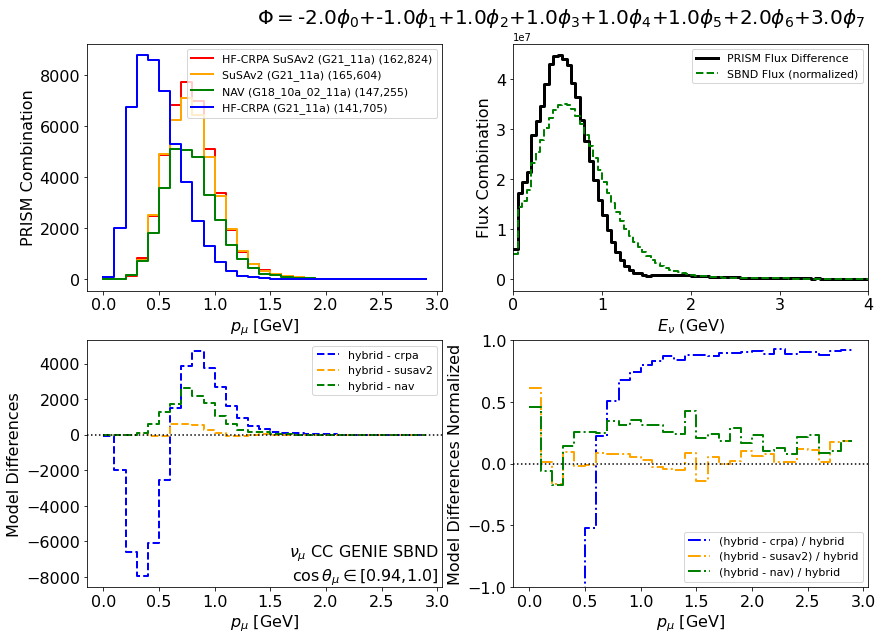

In [73]:
#Diff plots
coefficiencts1 = [-2.,-1.,1.,1.,1.,1.,2.,3.]
coefficiencts1_flux_formula = write_flux_formula(coefficiencts1)

hybrid_diffs = make_diff_hist(momentum_hists_hybrid,coefficiencts1)
g21_diffs = make_diff_hist(momentum_hists_g21,coefficiencts1)
g18_diffs = make_diff_hist(momentum_hists_g18,coefficiencts1)
crpa_diffs = make_diff_hist(momentum_hists_crpa,coefficiencts1)
flux_diffs = make_diff_hist(hist_sbnd_fluxes_np,coefficiencts1)

#Compare flux diff to flux
flux_diff_integral = np.sum(flux_diffs)*dE
sbnd_flux_integral = np.sum(sbnd_flux[0])*dE
sbnd_flux_comp = flux_diff_integral/sbnd_flux_integral*sbnd_flux[0]

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
ax_momentum, ax_flux, ax_diff, ax_weighted_diff = axs.flatten()
momentum_axs = [ax_momentum,ax_diff,ax_weighted_diff]

#Cos theta ax
makeplot.plot_hist_edges(momentum_hists_hybrid[0][1],hybrid_diffs,None
                         ,HYBRID_LABEL+f' ({round(costheta_counts_hybrid):,})',ax=ax_momentum,lw=2,color=MODEL_COLORS[3])
makeplot.plot_hist_edges(momentum_hists_hybrid[0][1],g21_diffs,None
                         ,G21_LABEL+f' ({round(costheta_counts_g21):,})',ax=ax_momentum,lw=2,color=MODEL_COLORS[1])
makeplot.plot_hist_edges(momentum_hists_hybrid[0][1],g18_diffs,None
                         ,G18_LABEL+f' ({round(costheta_counts_g18):,})',ax=ax_momentum,lw=2,color=MODEL_COLORS[2])
makeplot.plot_hist_edges(momentum_hists_hybrid[0][1],crpa_diffs,None
                         ,CRPA_LABEL+f' ({round(costheta_counts_crpa):,})',ax=ax_momentum,lw=2,color=MODEL_COLORS[0])
ax_momentum.set_ylabel('PRISM Combination')


#Flux ax
makeplot.plot_hist_edges(hist_sbnd_fluxes_np[0][1],flux_diffs,None,'PRISM Flux Difference',ax=ax_flux,lw=3,color='black')
makeplot.plot_hist_edges(sbnd_flux[1],sbnd_flux_comp,None,'SBND Flux (normalized)',ax=ax_flux,lw=2,ls='--',color='green')
ax_flux.set_xlim([0,4])
coeff_string = coefficiencts1_flux_formula
plotters.add_label(ax_flux,r'$\Phi=$'+coeff_string,where='toprightoutside',fontsize=20)
ax_flux.set_xlabel(r'$E_\nu$ (GeV)')
ax_flux.set_ylabel('Flux Combination')


#Diff ax
makeplot.plot_hist_edges(momentum_hists_hybrid[0][1]
                         ,hybrid_diffs-crpa_diffs
                         ,None
                         ,MODEL_NAMES[3]+' - '+MODEL_NAMES[0]
                         ,ax=ax_diff
                         ,lw=2
                         ,ls='--'
                         ,color=MODEL_COLORS[0])
makeplot.plot_hist_edges(momentum_hists_hybrid[0][1]
                         ,hybrid_diffs-g21_diffs
                         ,None
                         ,MODEL_NAMES[3]+' - '+MODEL_NAMES[1]
                         ,ax=ax_diff
                         ,lw=2
                         ,ls='--'
                         ,color=MODEL_COLORS[1])
makeplot.plot_hist_edges(momentum_hists_hybrid[0][1]
                         ,hybrid_diffs-g18_diffs
                         ,None
                         ,MODEL_NAMES[3]+' - '+MODEL_NAMES[2]
                         ,ax=ax_diff
                         ,lw=2
                         ,ls='--'
                         ,color=MODEL_COLORS[2])
ax_diff.axhline(0,ls=':',color='black')
ax_diff.set_ylabel('Model Differences')
plotters.add_label(ax_diff
                   ,SIM_LABEL+'\n'+r'$\cos\theta_\mu \in$'+f'[{COSTHETA_BINS[costheta_bin]},{COSTHETA_BINS[costheta_bin+1]}]'
                   ,where='bottomright',fontsize=16)

#Weighted diff ax
makeplot.plot_hist_edges(momentum_hists_hybrid[0][1]
                         ,(hybrid_diffs-crpa_diffs)/hybrid_diffs
                         ,None
                         ,'('+MODEL_NAMES[3]+' - '+MODEL_NAMES[0]+')'+f' / {MODEL_NAMES[3]}'
                         ,ax=ax_weighted_diff
                         ,lw=2
                         ,ls='-.'
                         ,color=MODEL_COLORS[0])
makeplot.plot_hist_edges(momentum_hists_hybrid[0][1]
                         ,(hybrid_diffs-g21_diffs)/hybrid_diffs
                         ,None
                         ,'('+MODEL_NAMES[3]+' - '+MODEL_NAMES[1]+')'+f' / {MODEL_NAMES[3]}'
                         ,ax=ax_weighted_diff
                         ,lw=2
                         ,ls='-.'
                         ,color=MODEL_COLORS[1])
makeplot.plot_hist_edges(momentum_hists_hybrid[0][1]
                         ,(hybrid_diffs-g18_diffs)/hybrid_diffs
                         ,None
                         ,'('+MODEL_NAMES[3]+' - '+MODEL_NAMES[2]+')'+f' / {MODEL_NAMES[3]}'
                         ,ax=ax_weighted_diff
                         ,lw=2
                         ,ls='-.'
                         ,color=MODEL_COLORS[2])
ax_weighted_diff.set_ylabel('Model Differences Normalized')
ax_weighted_diff.axhline(0,ls=':',color='black')
ax_weighted_diff.set_ylim([-1,1])

for ax in momentum_axs:
  ax.set_xlabel(r'$p_\mu$ [GeV]')
for ax in axs.flatten():
  ax.legend()
  plotters.set_style(ax,legend_size=11)
if save_plots:
  plotters.save_plot(f'prism_diff_comp_momentum',fig=fig,folder_name=PLOTS_DIR,overwrite=False)
  tt=0
if close_plots:
  plt.close(fig)

In [245]:
flux_ratio_integral

nan

## Testing

In [ ]:
hist = hists_flux[3]
dE = hist.axis().edges()[1] - hist.axis().edges()[0]
integral = np.sum(hist.values())*dE
integral

ValueError: x and y must have same first dimension, but have shapes (201,) and (9,)

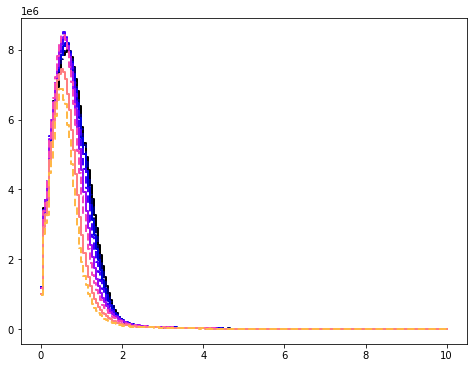

In [200]:
#Plot all fluxes on same plot
fig,ax = plt.subplots(figsize=(8,6))
for i in range(len(PRISM_BINS)-2):
  makeplot.plot_hist_edges(hist_sbnd_fluxes_np[i][1]
                           ,hist_sbnd_fluxes_np[i][0]
                           ,None
                           ,PRISM_LABELS[i]
                           ,ax=ax
                           ,lw=2
                           ,color=PRISM_COLORS[i]
                           ,ls='-' if i % 2 == 0 else '--')
makeplot.plot_hist_edges(sbnd_flux[1],sbnd_flux[0],None,'Total',ax=ax,lw=3,color='black')

[1.13740339 1.10781487 1.29069411 1.20221953 1.02431049 1.2323045
 1.28983251 1.24410369 1.32620203 1.31344769 1.28201206 1.33962041
 1.38837271 1.39532123 1.42581322 1.56381502 1.62943707 1.79775985
 2.09208849 2.63560096] [1.18254212 1.28727003 1.16612988 1.20600159 1.2350934  1.19189995
 1.16728138 1.19534494 1.19904776 1.31509738 1.24125841 1.23659839
 1.20010273 1.3532194  1.4888246  1.41981208 1.60445277 1.77816716
 2.04905792 2.62449133]


/tmp/ipykernel_20886/4195651116.py:15: RuntimeWarning: divide by zero encountered in true_divide
  flux_ratios = hist_sbnd_fluxes_np[1][0]/hist_sbnd_fluxes_np[-1][0]
/tmp/ipykernel_20886/4195651116.py:15: RuntimeWarning: invalid value encountered in true_divide
  flux_ratios = hist_sbnd_fluxes_np[1][0]/hist_sbnd_fluxes_np[-1][0]


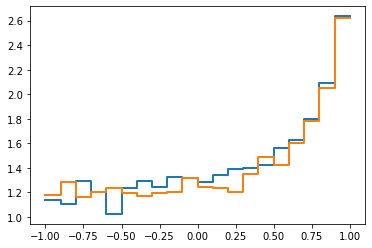

In [173]:
#Take ratios between model hists - do same for their flux histograms

costheta_hists_hybrid = [np.histogram(dfs_hybrid[i].costheta
                                      ,weights=dfs_hybrid[i].event_weight
                                      ,bins=np.arange(-1,1.1,0.1))\
                          for i in range(len(PRISM_BINS)-2)]
hybrid_ratios = costheta_hists_hybrid[1][0]/costheta_hists_hybrid[-1][0]

costheta_hists_g21 = [np.histogram(dfs_g21[i].costheta
                                      ,weights=dfs_g21[i].event_weight
                                      ,bins=np.arange(-1,1.1,0.1))\
                          for i in range(len(PRISM_BINS)-2)]
g21_ratios = costheta_hists_g21[1][0]/costheta_hists_g21[-1][0]
print(hybrid_ratios,g21_ratios)
flux_ratios = hist_sbnd_fluxes_np[1][0]/hist_sbnd_fluxes_np[-1][0]
flux_ratios = np.array([0 if np.isnan(ratio) or np.isinf(ratio) else ratio for ratio in flux_ratios])
len(flux_ratios),len(hist_sbnd_fluxes_np[0][-1])
#makeplot.plot_hist_edges(hist_sbnd_fluxes_np[0][1],flux_ratios,None,r'$\nu_\mu$ Flux',lw=2)
makeplot.plot_hist_edges(costheta_hists_hybrid[0][1],hybrid_ratios,None,r'$\cos\theta_\mu$',lw=2)
makeplot.plot_hist_edges(costheta_hists_hybrid[0][1],g21_ratios,None,r'$\cos\theta_\mu$',lw=2)
#plt.hist(flux_ratios,bins=hist_sbnd_fluxes_np[0][1],histtype='step',lw=2)
#ratio_0_to_7 = 
  

In [16]:
from sbnd.constants import *
ARGON_DENSITY*SBND_VOLUME
1/((1.973e-14)**2)
dfs_crpa[0]['xsecs'].values/GeV2perm2

array([1.7583e-41, 1.8955e-41, 1.0669e-41, ..., 1.6121e-41, 1.2577e-41,
       1.4216e-41], dtype=float32)

In [48]:
#Get prism area
from sbnd import prism
PRISM_RADII = [prism.calc_rf(theta) for theta in PRISM_BINS]
PRISM_RADII

[0.0,
 38.39739949755875,
 76.79573473546127,
 115.19594154526906,
 153.5989559409982,
 192.00571421039345,
 230.41715300625987,
 268.83420943786945,
 307.25782116246245,
 345.68892647686266]

(26483.206961000644, 50975.074335888334)

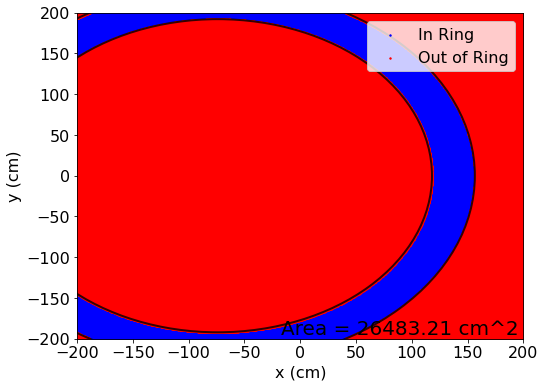

In [161]:
prism.calc_prism_area(PRISM_RADII[5],PRISM_RADII[6],return_ring_area=True,show_plot=True)

In [157]:


n = int(1e3)
ratios_1 = [np.pi*PRISM_RADII[1]**2/prism.calc_prism_area(PRISM_RADII[0],PRISM_RADII[1],n=n) for i in range(40)]

n = int(1e4)
ratios_2 = [np.pi*PRISM_RADII[1]**2/prism.calc_prism_area(PRISM_RADII[0],PRISM_RADII[1],n=n) for i in range(40)]

n = int(1e5)
ratios_3 = [np.pi*PRISM_RADII[1]**2/prism.calc_prism_area(PRISM_RADII[0],PRISM_RADII[1],n=n) for i in range(40)]

n = int(1e6)
ratios_4 = [np.pi*PRISM_RADII[1]**2/prism.calc_prism_area(PRISM_RADII[0],PRISM_RADII[1],n=n) for i in range(40)]

n = int(1e7)
ratios_5 = [np.pi*PRISM_RADII[1]**2/calc_prism_area(PRISM_RADII[0],PRISM_RADII[1],n=n) for i in range(40)]

/tmp/ipykernel_15237/1888262105.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  ratios_1 = [np.pi*PRISM_RADII[1]**2/prism.calc_prism_area(PRISM_RADII[0],PRISM_RADII[1],n=n) for i in range(40)]


<ErrorbarContainer object of 3 artists>

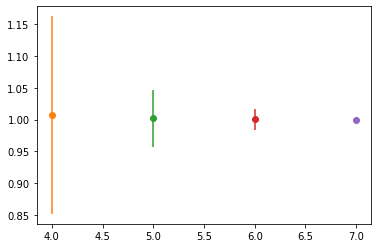

In [159]:
plt.errorbar(3,np.mean(ratios_1),yerr=np.std(ratios_1),fmt='o',label='n = 1e3')
plt.errorbar(4,np.mean(ratios_2),yerr=np.std(ratios_2),fmt='o',label='n = 1e4')
plt.errorbar(5,np.mean(ratios_3),yerr=np.std(ratios_3),fmt='o',label='n = 1e5')
plt.errorbar(6,np.mean(ratios_4),yerr=np.std(ratios_4),fmt='o',label='n = 1e6')
plt.errorbar(7,np.mean(ratios_5),yerr=np.std(ratios_5),fmt='o',label='n = 1e7')
